# Google Data Project

In [2]:
import numpy as np           
import matplotlib.pyplot as plt
from scipy import signal
import os
import fnmatch
import astropy.units as u
from astropy.time import Time
from sunpy.time import parse_time
from astropy.table import Table
import pandas as pd
import matplotlib
%matplotlib inline  

Import the data from files: 

In [3]:
import DataCenterImport as DC
dat=DC.DataCenter('/Volumes/DataDisk/GoogleData/')

Alternatively, to reload the data:

In [3]:
import importlib
importlib.reload(DC)
dat=DC.DataCenter('/Volumes/DataDisk/GoogleData/')

Reads and provides data sets for analysis:
            site_info - table of information for each site;
            nmdb_set - Neutron Monitor Database;
            error_set - Error rate of data center;
            wx_set - weather info for each data center;
            goes_set - P7 high energy particle flux information;

Compute average error for each building

In [4]:
error_ave = np.array([np.mean(dat.error_set['rate'][dat.error_set['loc_id'] == idnum]) for idnum in dat.site_info['ID']])
error_std = np.array([np.std(dat.error_set['rate'][dat.error_set['loc_id'] == idnum]) for idnum in dat.site_info['ID']])

plot error rate vs altitude 

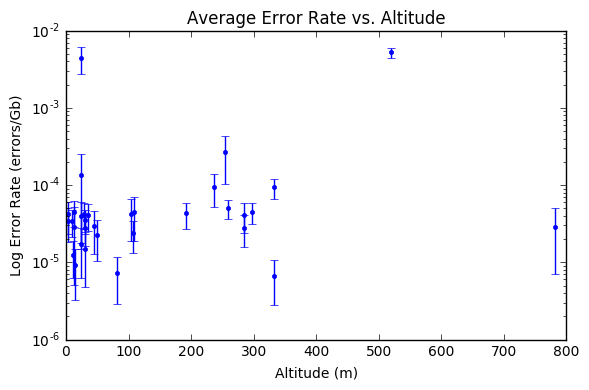

In [5]:
ax = plt.subplot(111)
ax.set_yscale("log", nonposy='clip')

plt.errorbar(dat.site_info['Altitude'], error_ave, yerr=error_std,fmt='.')
ax.set_xlabel('Altitude (m)')
ax.set_ylabel('Log Error Rate (errors/Gb)')
ax.set_title('Average Error Rate vs. Altitude')
plt.tight_layout()
plt.savefig('{0}{1}{2}'.format('/Users/mskirk/Desktop/GooglePlots/','ErrorAltitude','.png'), dpi=200)

Create a date range for each center id:

In [6]:
er_begin=[np.min(dat.error_set.index[dat.error_set['loc_id'] == idnum]) for idnum in dat.site_info['ID']]
er_end=[np.max(dat.error_set.index[dat.error_set['loc_id'] == idnum]) for idnum in dat.site_info['ID']]

wx_begin=[np.min(dat.wx_set.index[dat.wx_set['loc_id'] == idnum]) for idnum in dat.site_info['ID']]
wx_end=[np.max(dat.wx_set.index[dat.wx_set['loc_id'] == idnum]) for idnum in dat.site_info['ID']]


In [7]:
tbegin=[np.max([wx_begin[count],er_begin[count]]) for count in range(33)]
tend=[np.min([wx_end[count],er_end[count]]) for count in range(33)]

Non standard unit definition:

In [8]:
from astropy.units import cds
InHg = 3386.39 *u.Pa

Define sea level for pressure correction:

In [9]:
sealev = (760.00*u.cds.mmHg).to(u.Pa) # Conversion to Pascals 

$I_{\tt corr}=I_0e^{-\frac{\lambda}{\lambda_0}}$

$\lambda = {\tt sealevel} - P_0$

$P_0$ is the measured atmospheric pressure at the site.

Define attenuating scale length:

In [10]:
lambda0 = 9806.65 * u.Pa # stupid conversions between gram-force and SI units
# lambda0 = (100 gram-force/cm^2 * 98.0665 Pa/[gram-force/cm^2])
# lambda0 = 130 gram-force/cm^2 # Alternative scale height depending on particle energy

For each data center site, resample to 5 minute interval between the beginning and ending date of the error date. Linear interpolation over NAN's generated by upsampling. In this case the id_index is a list of cite id numbers.

In [11]:
id_index = 32 ## 0 to 32
errors=dat.error_set.where(dat.error_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample(
    '5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]

wx=dat.wx_set.where(dat.wx_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample('5T').interpolate(
    method='linear')[tbegin[id_index]:tend[id_index]]

goes=dat.goes_set.resample('5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]

nmdb=dat.nmdb_set.resample('5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]


Pressure correction factor:

Distribituted the $-1$ in the exponent to subtract sealevel from pressure (equation is vise versa)

In [12]:
atm_corr=(np.exp(((wx[['MaxSeaLevelPressureIn','MeanSeaLevelPressureIn','MinSeaLevelPressureIn']]*InHg)-sealev)/lambda0)).rename(index=str, columns={'MaxSeaLevelPressureIn':'MaxCorrection', 'MeanSeaLevelPressureIn':'MeanCorrection','MinSeaLevelPressureIn':'MinCorrection'})
atm_corr.index=pd.to_datetime(atm_corr.index,utc=True)

In [13]:
error_corr=atm_corr['MeanCorrection']*errors['rate']
error_mx=atm_corr['MaxCorrection']*errors['rate']
error_mn=atm_corr['MinCorrection']*errors['rate']
corrected_errors=(pd.concat([error_mx,error_corr,error_mn], axis=1, keys=['MaxRate','MeanRate','MinRate'])).dropna()


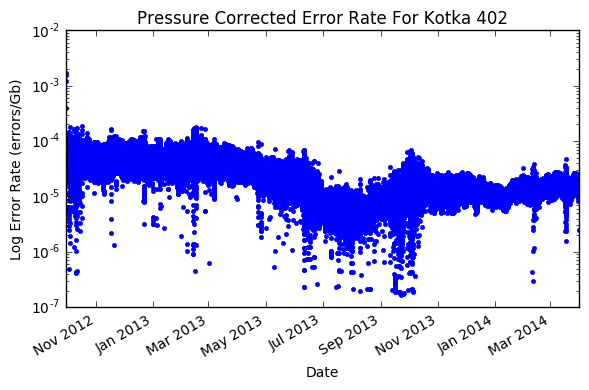

In [14]:
fig, ax = plt.subplots()
ax.set_yscale("log", nonposy='clip')
plt.errorbar(corrected_errors.index, corrected_errors['MeanRate'],fmt='.')
ax.set_xlabel('Date')
ax.set_ylabel('Log Error Rate (errors/Gb)')
ax.set_title('{0} {1} {2}'.format('Pressure Corrected Error Rate For',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index]))
fig.autofmt_xdate()
plt.tight_layout()


Do it again, but in a for loop with a save funtion:

/Users/mskirk/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


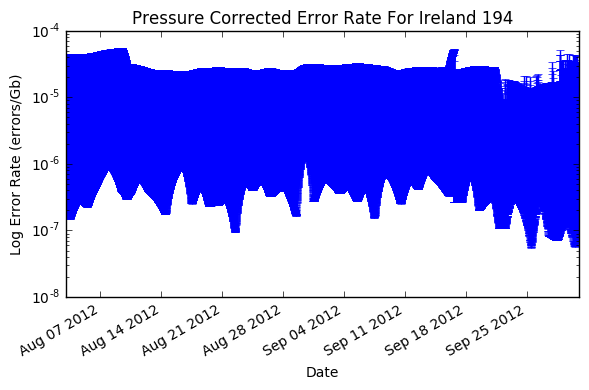

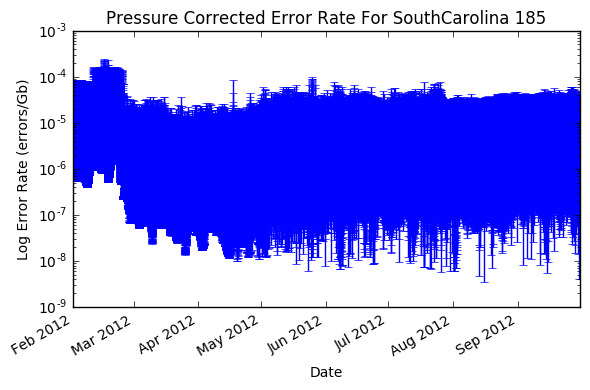

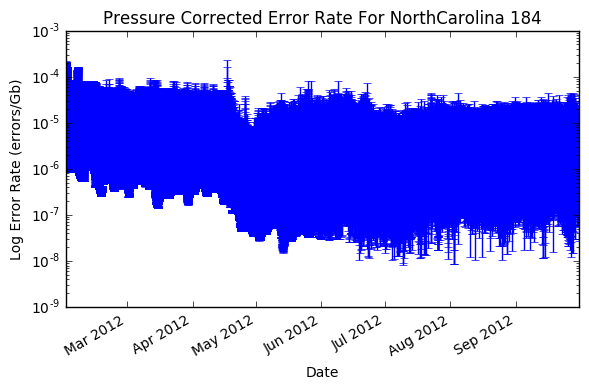

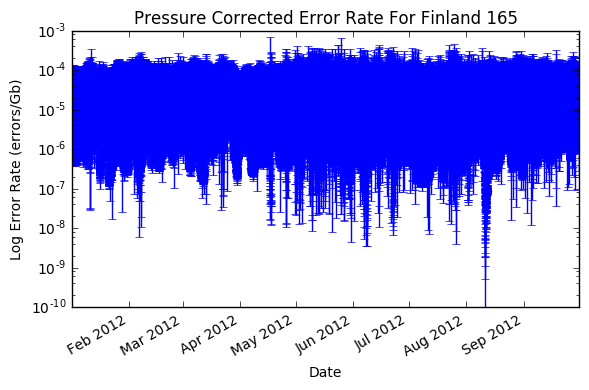

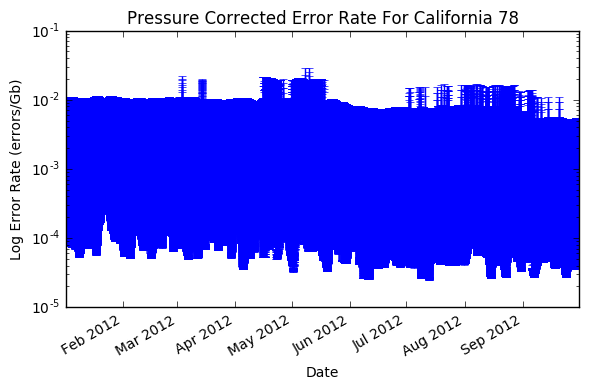

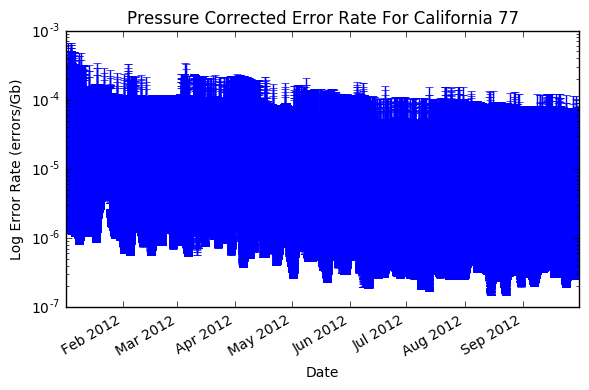

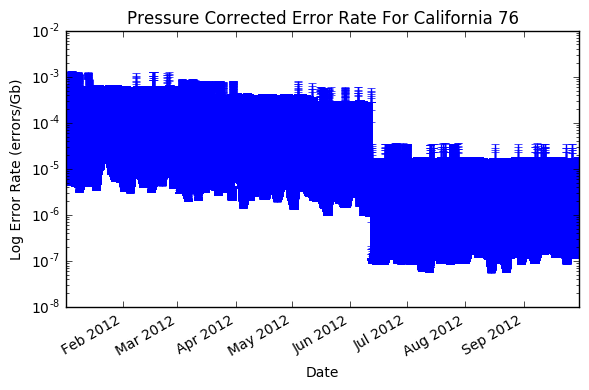

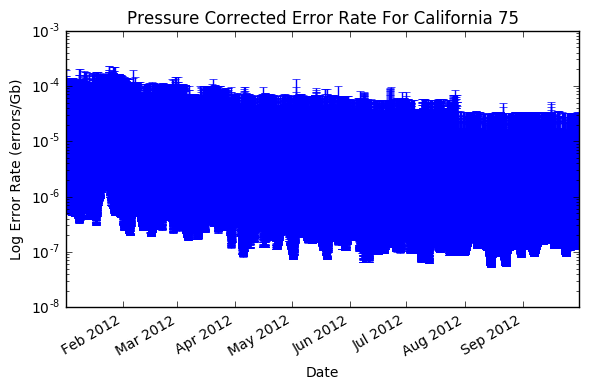

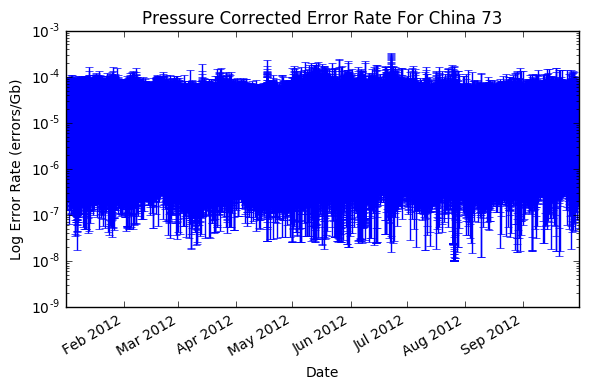

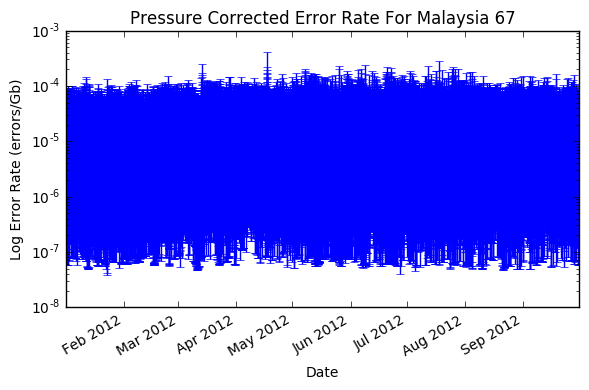

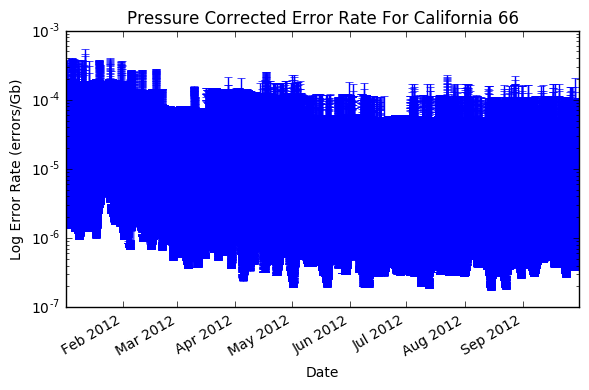

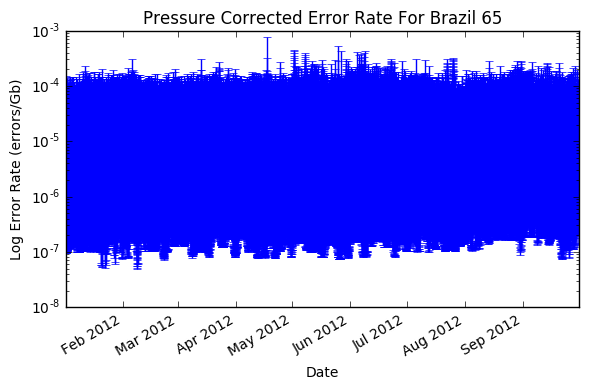

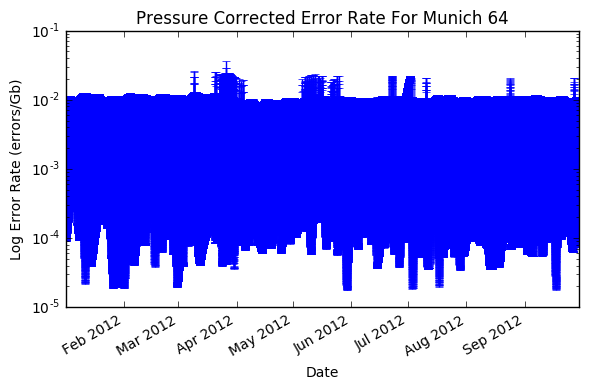

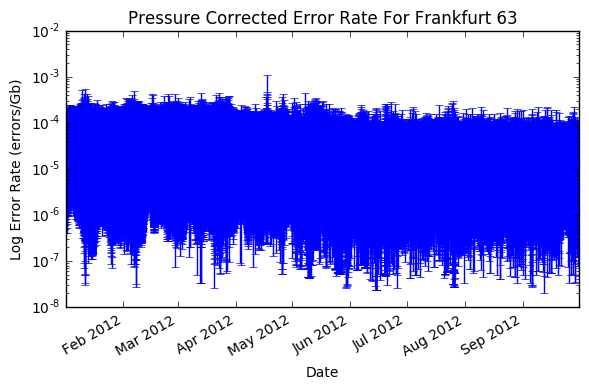

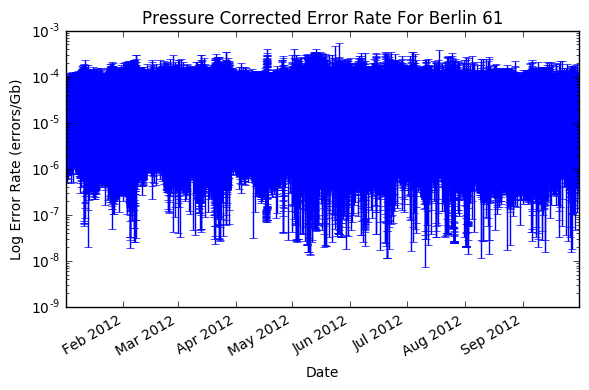

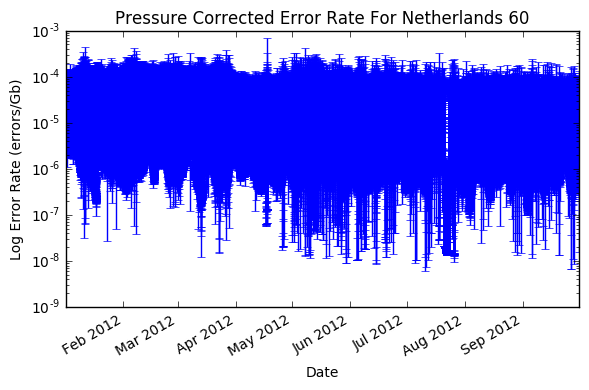

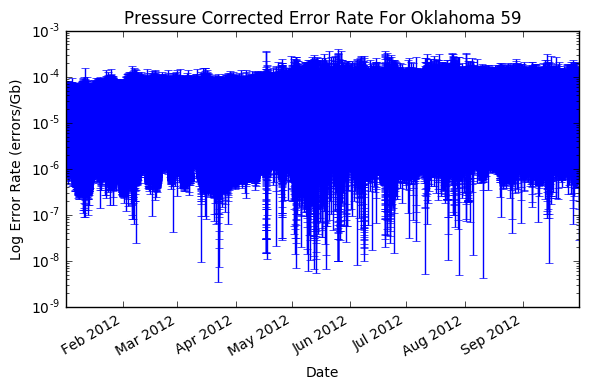

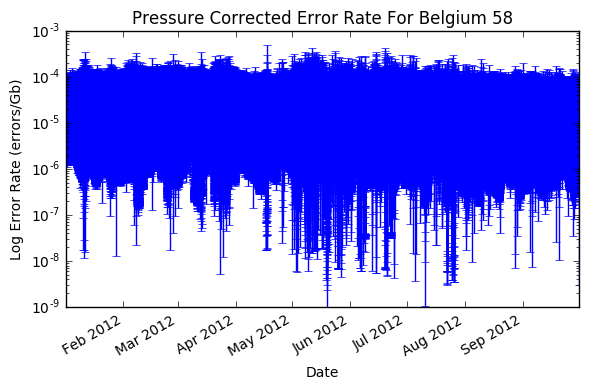

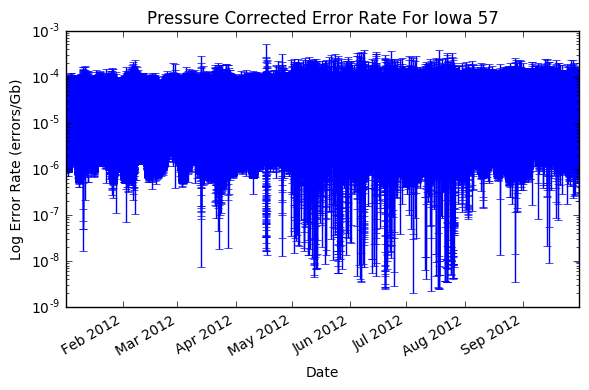

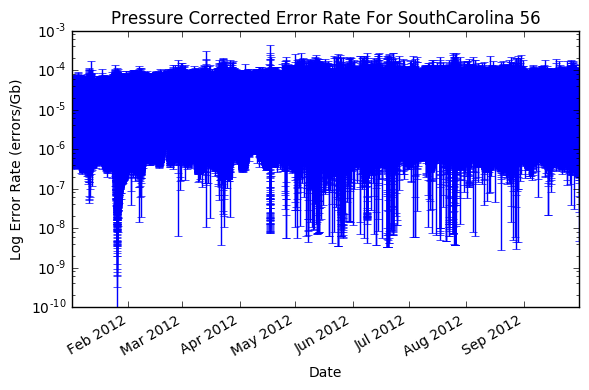

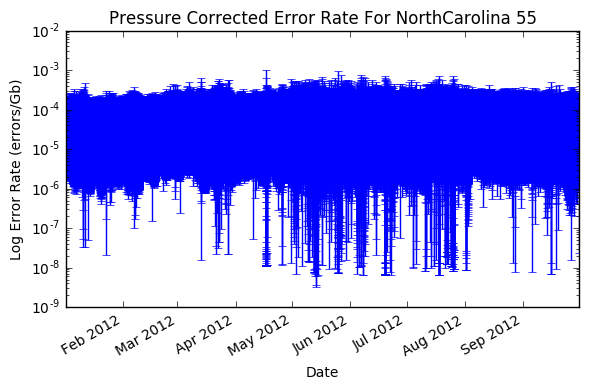

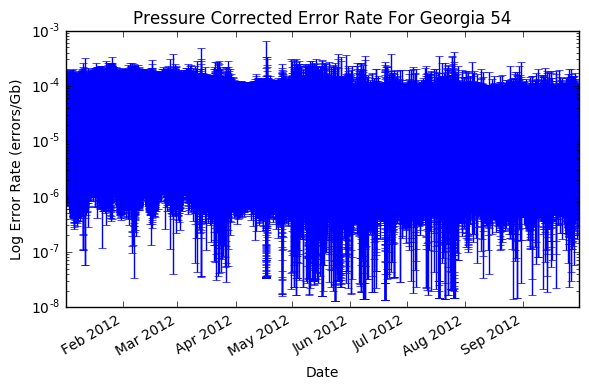

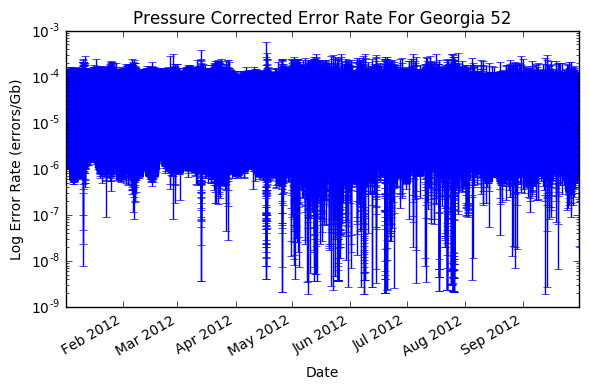

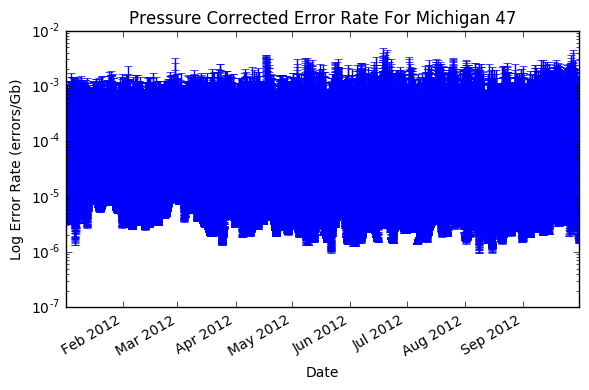

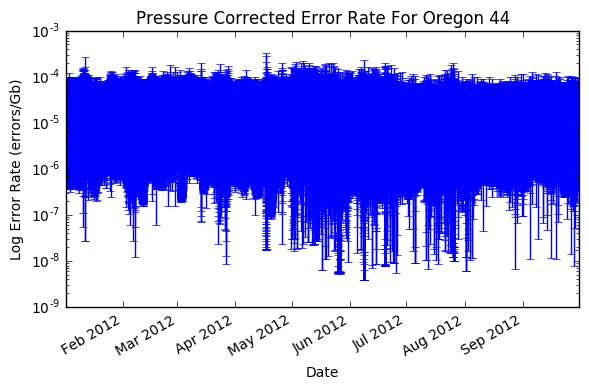

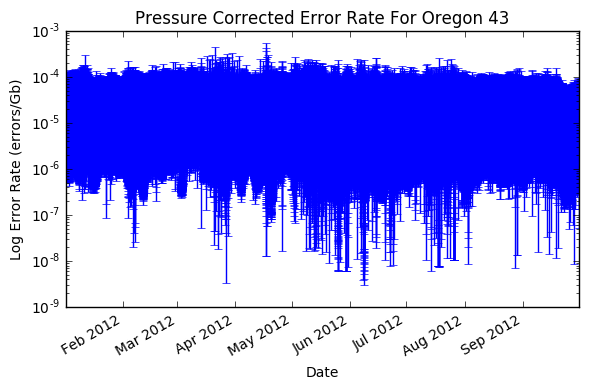

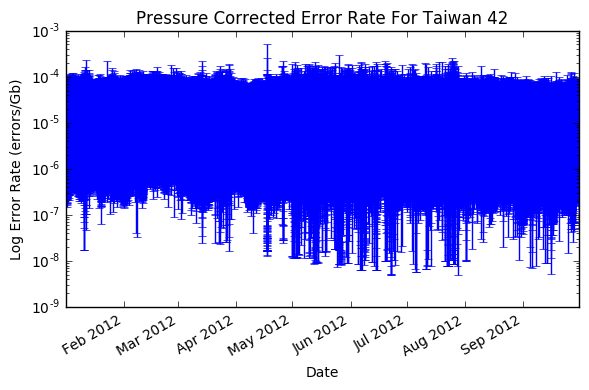

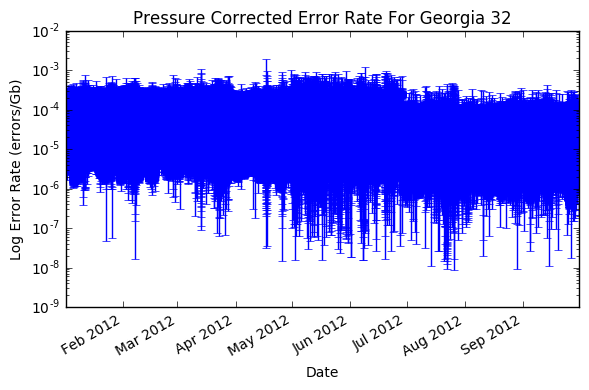

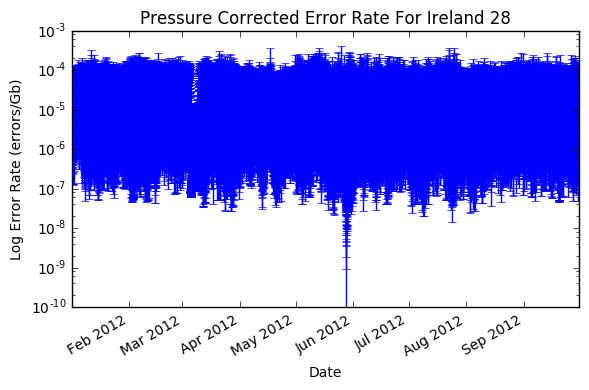

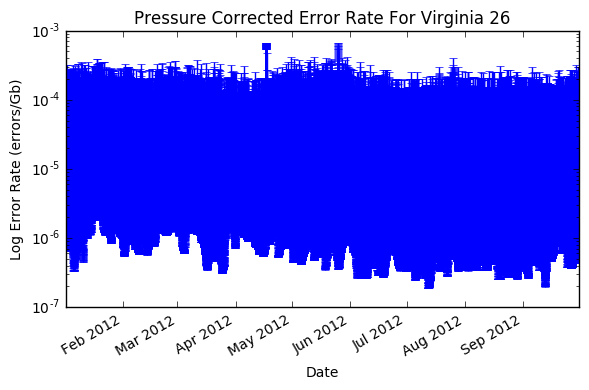

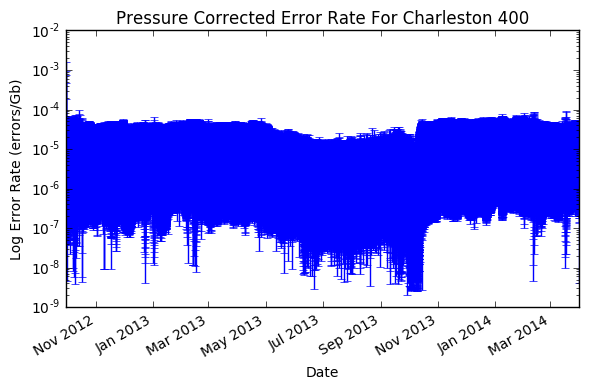

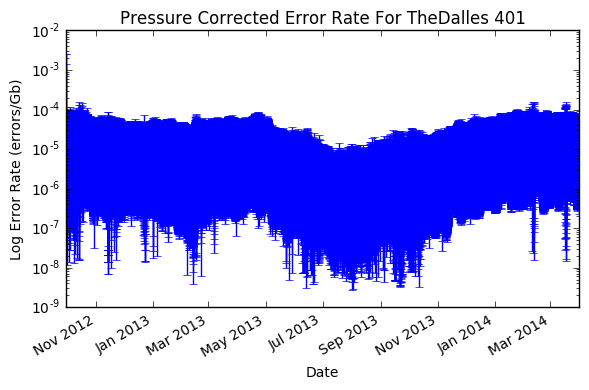

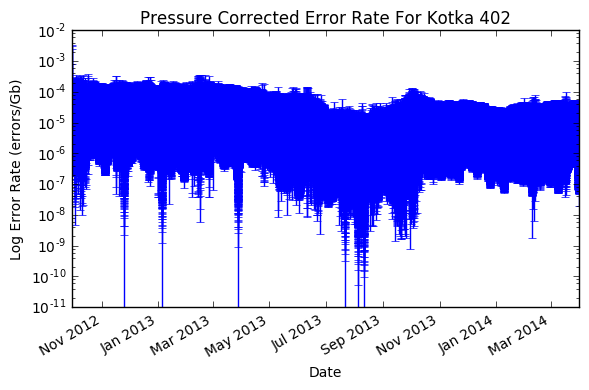

In [79]:
PCor_error_ave = np.zeros_like(error_ave)
PCor_error_std = np.zeros_like(error_ave)

for id_index in range(33):
    errors=dat.error_set.where(dat.error_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample(
        '5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]

    wx=dat.wx_set.where(dat.wx_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample('5T').interpolate(
        method='linear')[tbegin[id_index]:tend[id_index]]

    goes=dat.goes_set.resample('5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]

    nmdb=dat.nmdb_set.resample('5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]
    
    atm_corr=(np.exp(((wx[['MaxSeaLevelPressureIn','MeanSeaLevelPressureIn','MinSeaLevelPressureIn']]*InHg)-sealev)/lambda0)).rename(index=str, columns={'MaxSeaLevelPressureIn':'MaxCorrection', 'MeanSeaLevelPressureIn':'MeanCorrection','MinSeaLevelPressureIn':'MinCorrection'})
    atm_corr.index=pd.to_datetime(atm_corr.index,utc=True)
    
    error_corr=atm_corr['MeanCorrection']*errors['rate']
    error_mx=atm_corr['MaxCorrection']*errors['rate']
    error_mn=atm_corr['MinCorrection']*errors['rate']

    PCor_error_ave[id_index]=np.mean(error_corr)
    PCor_error_std[id_index]=np.std(error_corr)
    
    corrected_errors=(pd.concat([error_mx,error_corr,error_mn], axis=1, keys=['MaxRate','MeanRate','MinRate'])).dropna()
    
    fig, ax = plt.subplots()
    ax.set_yscale("log", nonposy='clip')
    plt.errorbar(corrected_errors.index, corrected_errors['MeanRate'],fmt='.', markersize=0.1)
    #plt.errorbar(corrected_errors.index, corrected_errors['MeanRate'], yerr=[corrected_errors['MinRate'],corrected_errors['MaxRate']],fmt='.', markersize=0.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Error Rate (errors/Gb)')
    ax.set_title('{0} {1} {2}'.format('Pressure Corrected Error Rate For',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index]))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig('{0}{1}{2}{3}'.format('/Users/mskirk/Desktop/GooglePlots/',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index],'.png'), dpi=200)


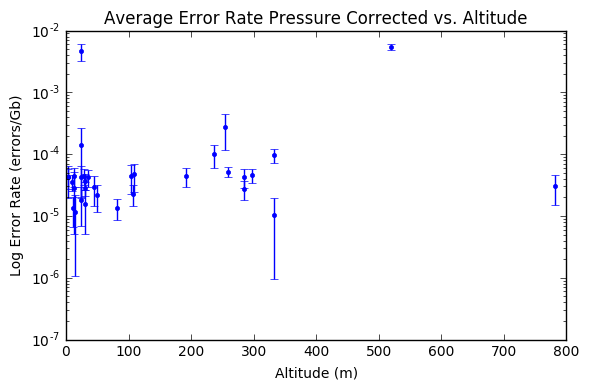

In [21]:
ax = plt.subplot(111)
ax.set_yscale("log", nonposy='clip')

plt.errorbar(dat.site_info['Altitude'], PCor_error_ave, yerr=PCor_error_std,fmt='.')
ax.set_xlabel('Altitude (m)')
ax.set_ylabel('Log Error Rate (errors/Gb)')
ax.set_title('Average Error Rate Pressure Corrected vs. Altitude')
plt.tight_layout()
plt.savefig('{0}{1}{2}'.format('/Users/mskirk/Desktop/GooglePlots/','PCorrErrorAltitude','.png'), dpi=200)

Now Let's investegated the two known GLEs:


In [22]:
GLE1=pd.to_datetime(['2012-05-17 01:55','2012-05-17 08:00'] , utc=True)
GLE1_begin=pd.to_datetime('2012-05-16 12:00', utc=True)
GLE1_end=pd.to_datetime('2012-05-18 00:00', utc=True)

GLE2=pd.to_datetime(['2014-01-06 08:15', '2014-01-06 16:15'], utc=True)
GLE2_begin=pd.to_datetime('2014-01-06 00:00', utc=True)
GLE2_end=pd.to_datetime('2014-01-07 12:00', utc=True)

GLE 1 Plots:

/Users/mskirk/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


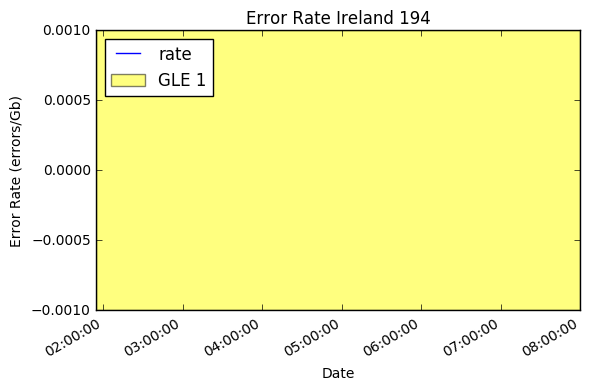

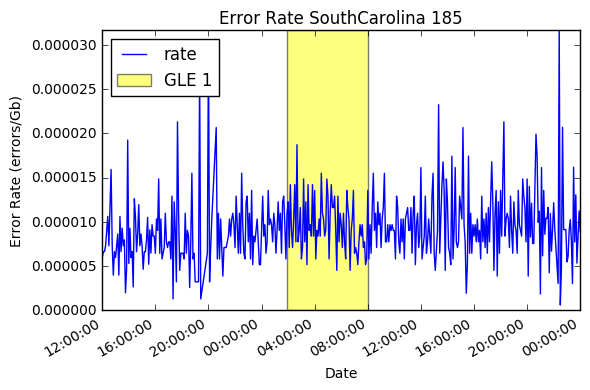

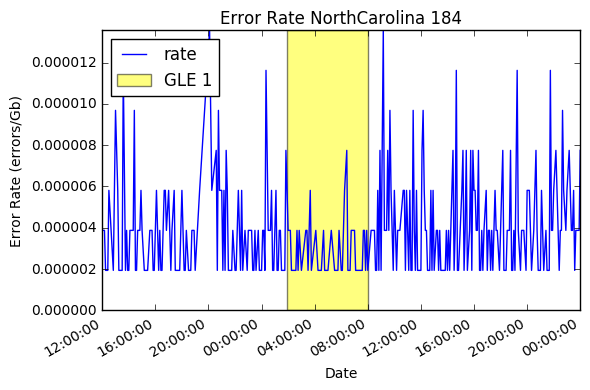

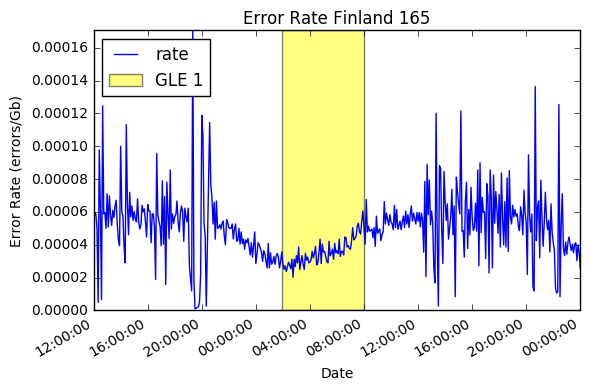

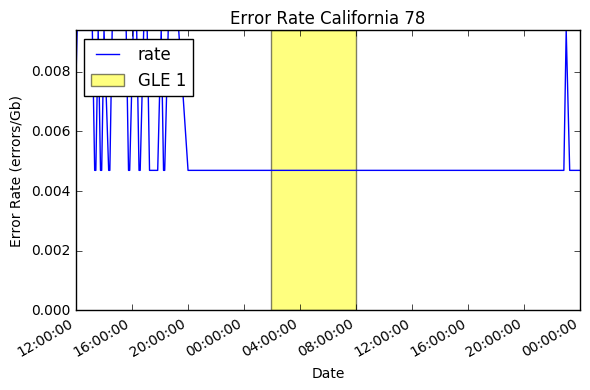

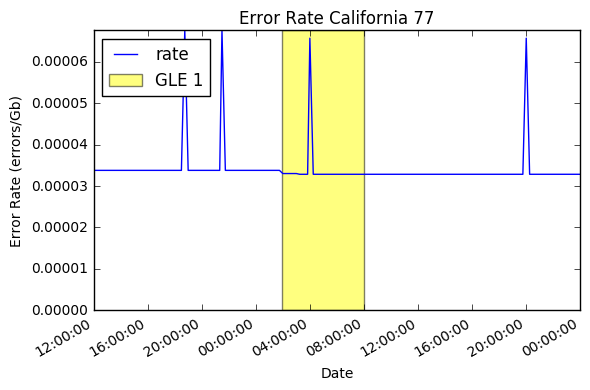

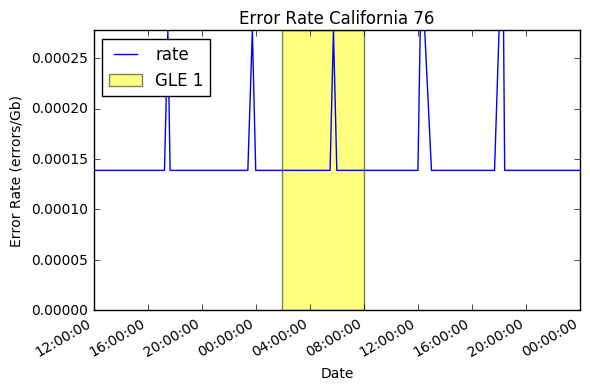

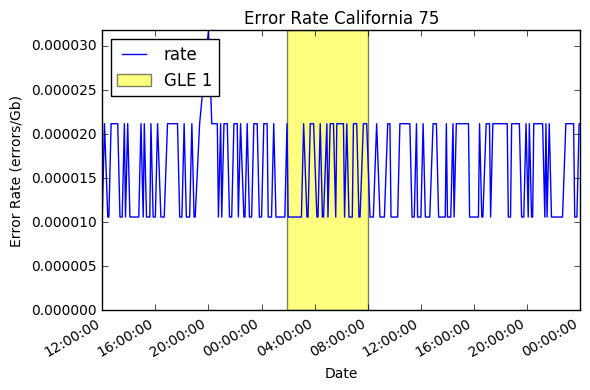

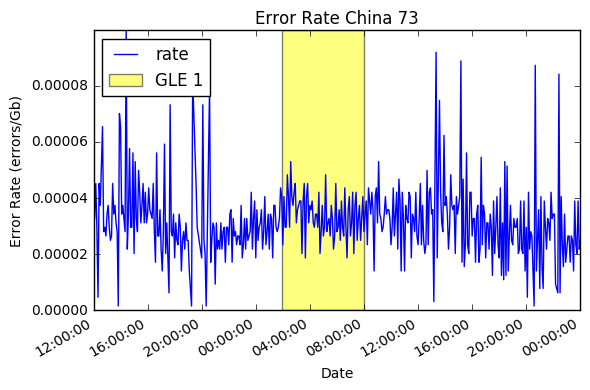

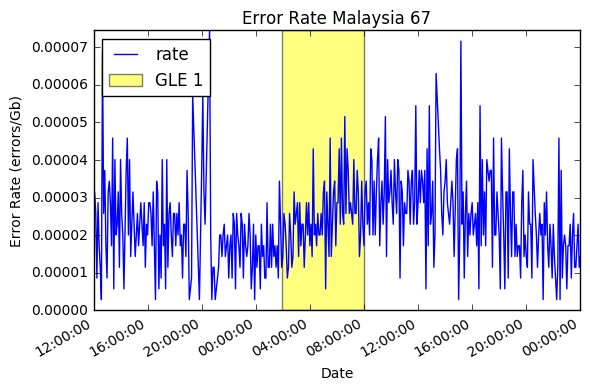

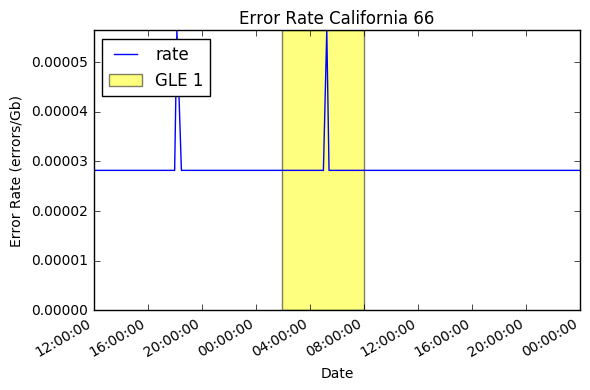

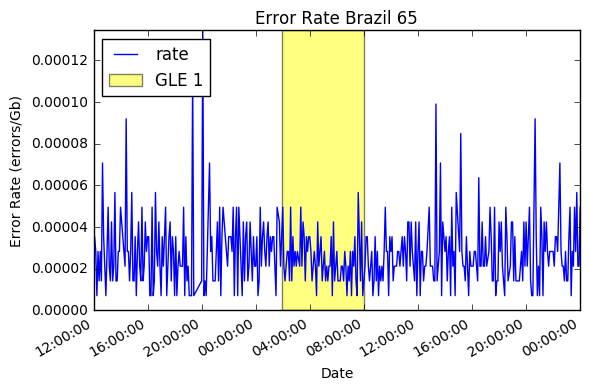

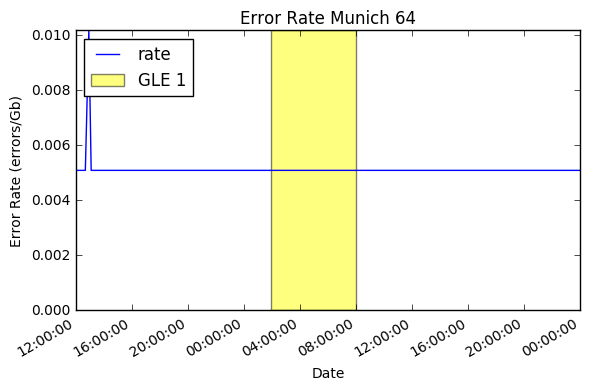

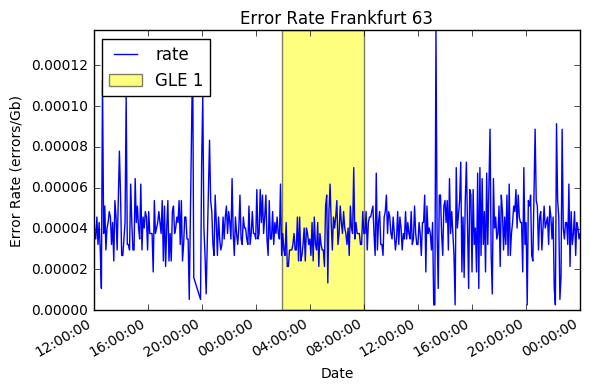

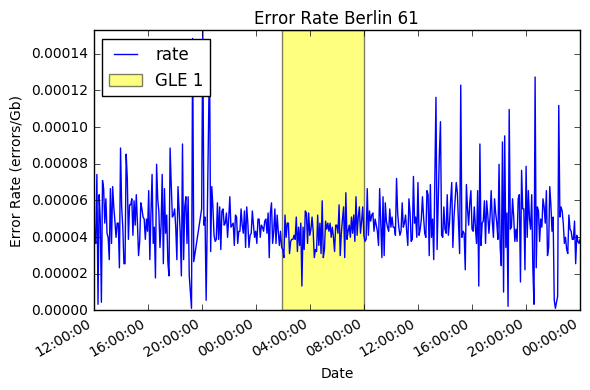

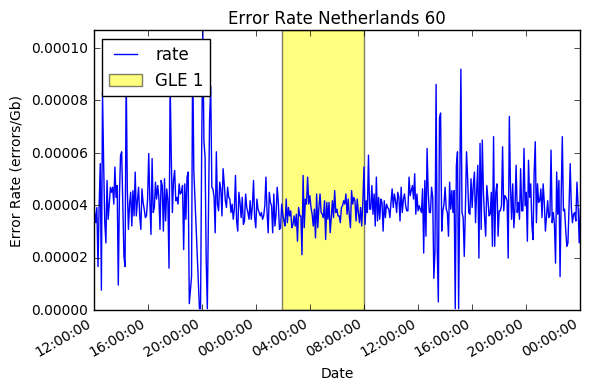

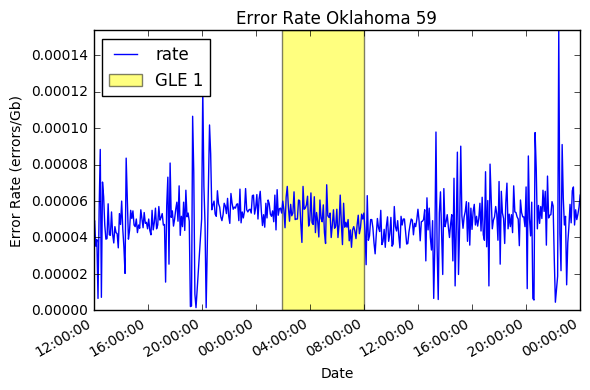

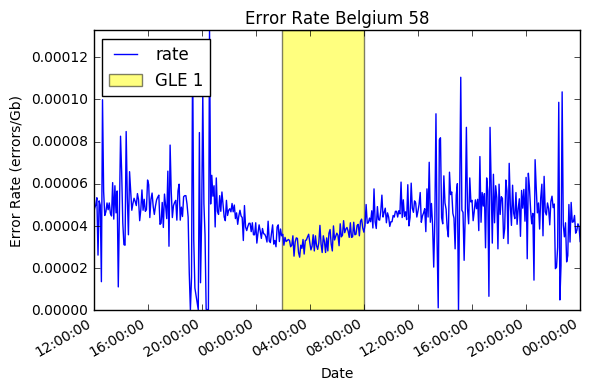

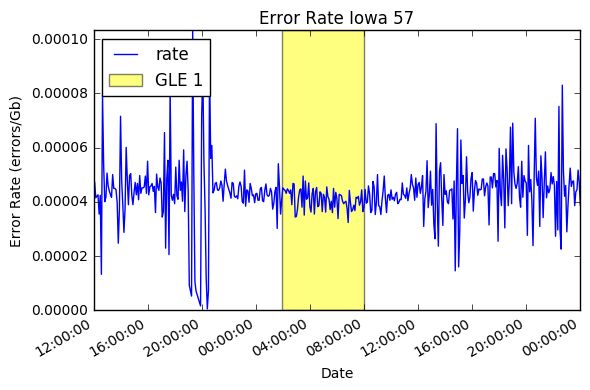

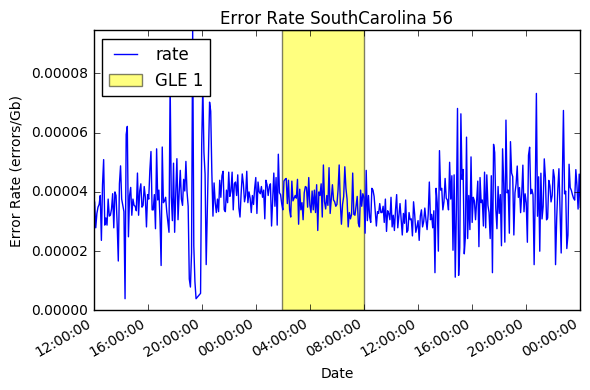

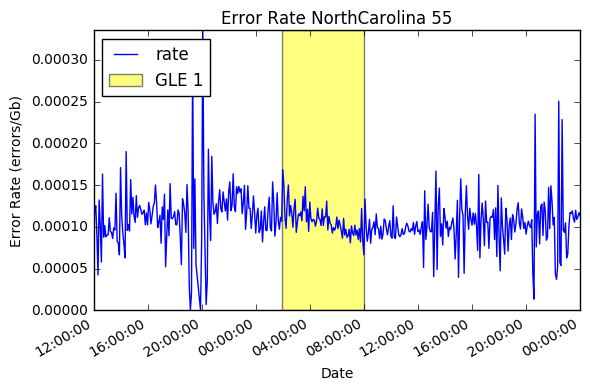

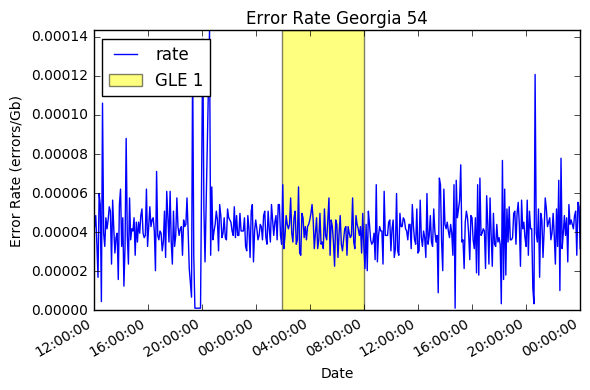

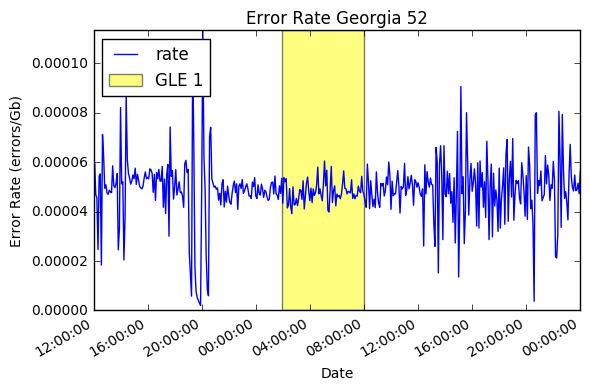

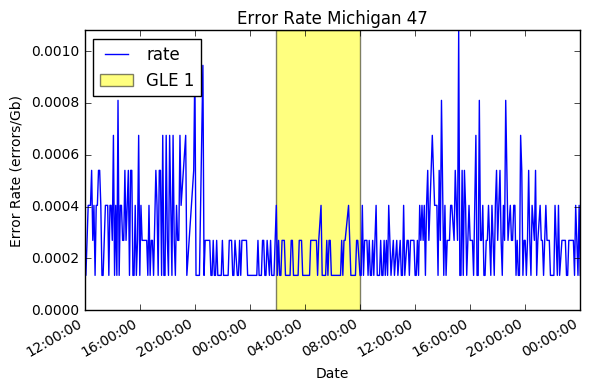

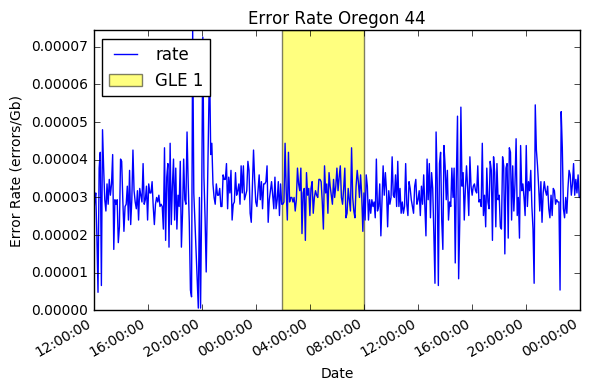

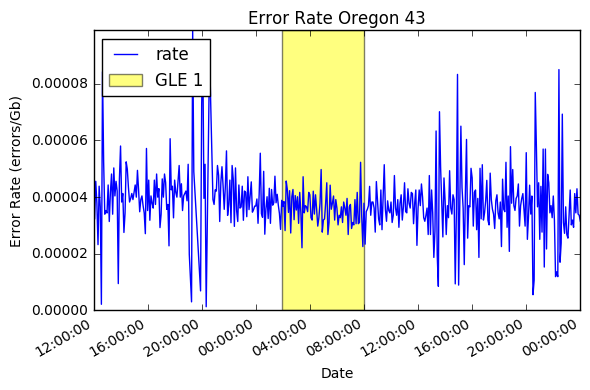

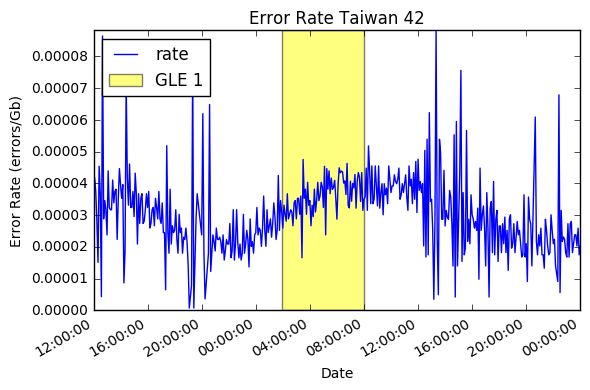

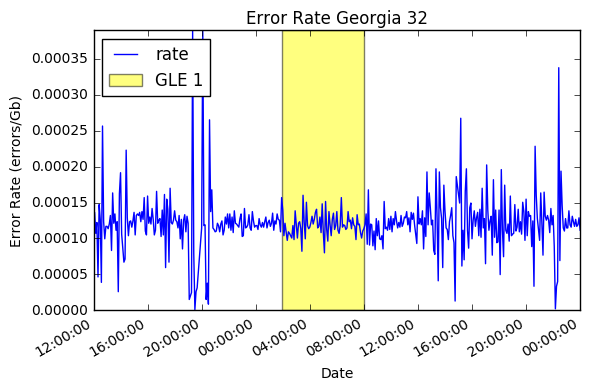

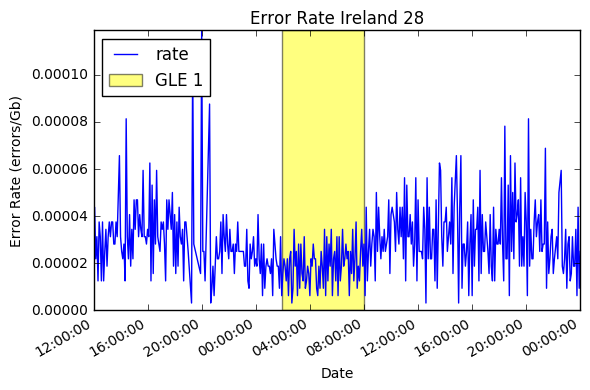

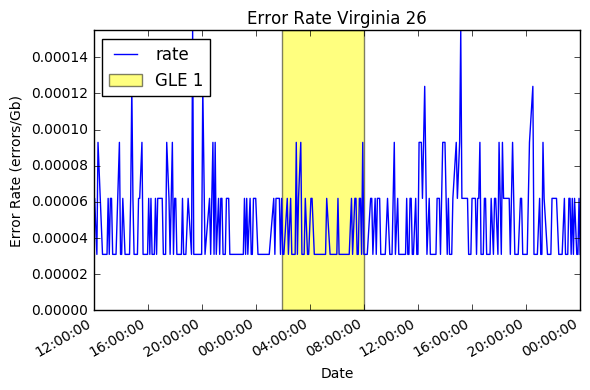

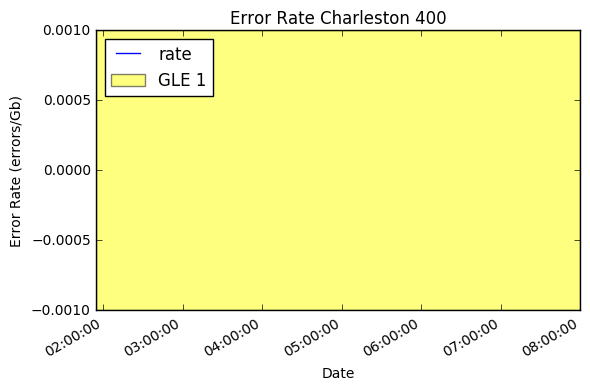

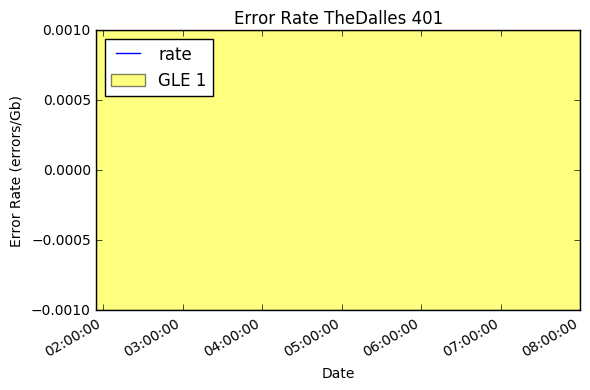

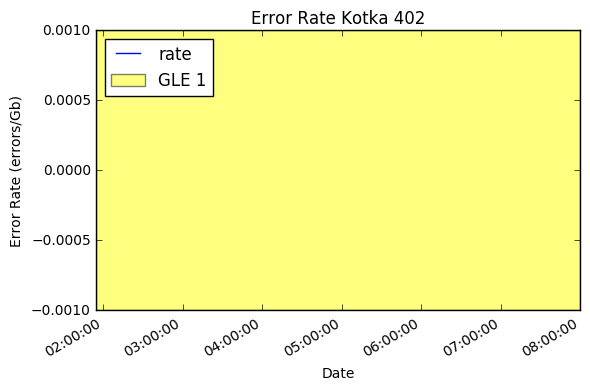

In [38]:
for id_index in range(33):
    errors=dat.error_set.where(dat.error_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample(
        '5T').interpolate(method='linear')[GLE1_begin:GLE1_end]

    wx=dat.wx_set.where(dat.wx_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample('5T').interpolate(
        method='linear')[GLE1_begin:GLE1_end]

    goes=dat.goes_set.resample('5T').interpolate(method='linear')[GLE1_begin:GLE1_end]

    nmdb=dat.nmdb_set.resample('5T').interpolate(method='linear')[GLE1_begin:GLE1_end]
    
    atm_corr=(np.exp(((wx[['MaxSeaLevelPressureIn','MeanSeaLevelPressureIn','MinSeaLevelPressureIn']]*InHg)-sealev)/lambda0)).rename(index=str, columns={'MaxSeaLevelPressureIn':'MaxCorrection', 'MeanSeaLevelPressureIn':'MeanCorrection','MinSeaLevelPressureIn':'MinCorrection'})
    atm_corr.index=pd.to_datetime(atm_corr.index,utc=True)
    
    error_corr=atm_corr['MeanCorrection']*errors['rate']
    error_mx=atm_corr['MaxCorrection']*errors['rate']
    error_mn=atm_corr['MinCorrection']*errors['rate']

    corrected_errors=(pd.concat([error_mx,error_corr,error_mn], axis=1, keys=['MaxRate','MeanRate','MinRate'])).dropna()
    
    fig, ax = plt.subplots(1)
    ylow, yhigh = ax.set_ylim([0,np.max(corrected_errors['MeanRate'])])
    plt.plot(errors.index, corrected_errors['MeanRate'])
    # Alternative plotting without pressure correction for comparison
    #ylow, yhigh = ax.set_ylim([0,np.max(errors['rate'])]) 
    #plt.plot(errors.index, errors['rate'])
    ax.fill_betweenx([ylow,yhigh], GLE1[0],GLE1[1], facecolor='yellow', alpha=0.5, label='GLE 1')    
    ax.set_xlabel('Date')
    ax.set_ylabel('Error Rate (errors/Gb)')
    ax.set_title('{0} {1} {2}'.format('Error Rate',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index]))
    ax.legend(loc='upper left')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig('{0}{1}{2}{3}'.format('/Users/mskirk/Desktop/GooglePlots/GLE1_',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index],'.png'), dpi=200)


GLE 2 Plots:

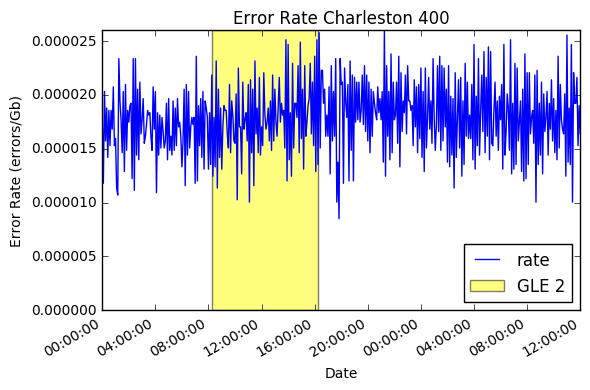

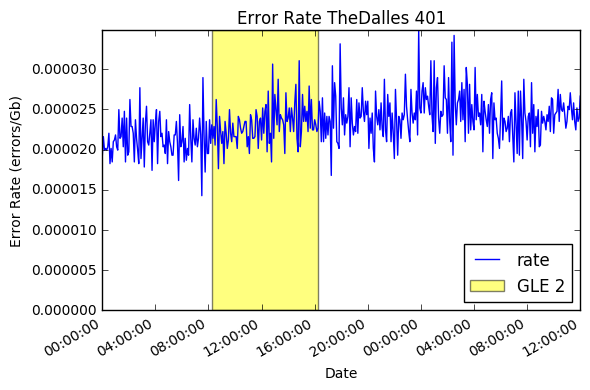

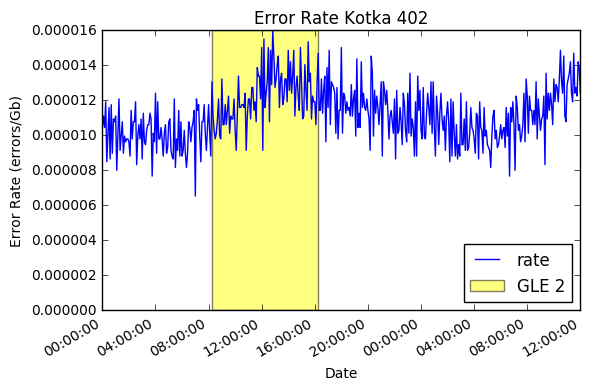

In [39]:
for id_index in [30,31,32]:
    errors=dat.error_set.where(dat.error_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample(
        '5T').interpolate(method='linear')[GLE2_begin:GLE2_end]

    wx=dat.wx_set.where(dat.wx_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample('5T').interpolate(
        method='linear')[GLE2_begin:GLE2_end]

    goes=dat.goes_set.resample('5T').interpolate(method='linear')[GLE2_begin:GLE2_end]

    nmdb=dat.nmdb_set.resample('5T').interpolate(method='linear')[GLE2_begin:GLE2_end]
    
    atm_corr=(np.exp(((wx[['MaxSeaLevelPressureIn','MeanSeaLevelPressureIn','MinSeaLevelPressureIn']]*InHg)-sealev)/lambda0)).rename(index=str, columns={'MaxSeaLevelPressureIn':'MaxCorrection', 'MeanSeaLevelPressureIn':'MeanCorrection','MinSeaLevelPressureIn':'MinCorrection'})
    atm_corr.index=pd.to_datetime(atm_corr.index,utc=True)
    
    error_corr=atm_corr['MeanCorrection']*errors['rate']
    error_mx=atm_corr['MaxCorrection']*errors['rate']
    error_mn=atm_corr['MinCorrection']*errors['rate']

    corrected_errors=(pd.concat([error_mx,error_corr,error_mn], axis=1, keys=['MaxRate','MeanRate','MinRate'])).dropna()
    
    fig, ax = plt.subplots(1)
    ylow, yhigh = ax.set_ylim([0,np.max(corrected_errors['MeanRate'])])
    plt.plot(errors.index, corrected_errors['MeanRate'])
    # Alternative plotting without pressure correction for comparison
    #ylow, yhigh = ax.set_ylim([0,np.max(errors['rate'])])
    #plt.plot(errors.index, errors['rate'])
    ax.fill_betweenx([ylow,yhigh], GLE2[0],GLE2[1], facecolor='yellow', alpha=0.5, label='GLE 2')    
    ax.set_xlabel('Date')
    ax.set_ylabel('Error Rate (errors/Gb)')
    ax.set_title('{0} {1} {2}'.format('Error Rate',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index]))
    ax.legend(loc='lower right')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig('{0}{1}{2}{3}'.format('/Users/mskirk/Desktop/GooglePlots/GLE2_',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index],'.png'), dpi=200)



Pressure vs. Error rate Plots:

/Users/mskirk/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


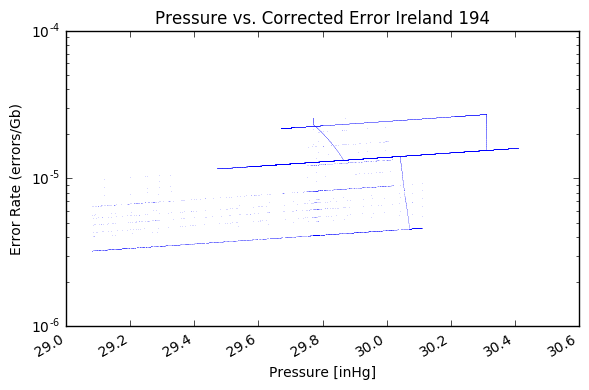

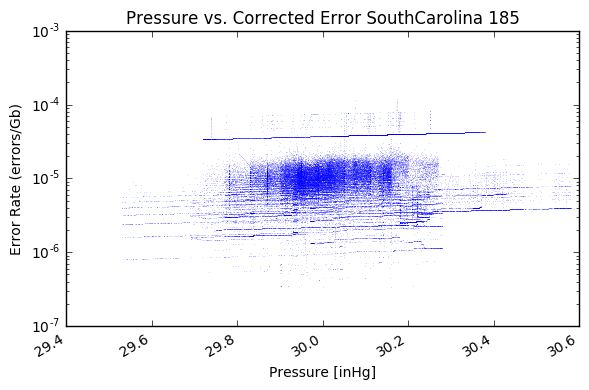

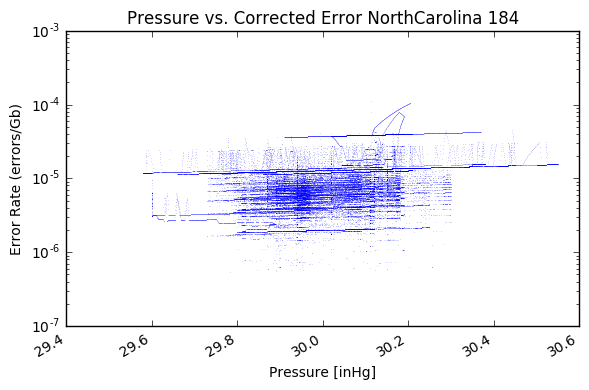

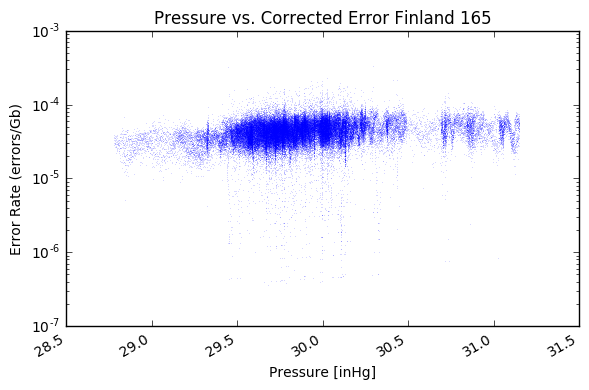

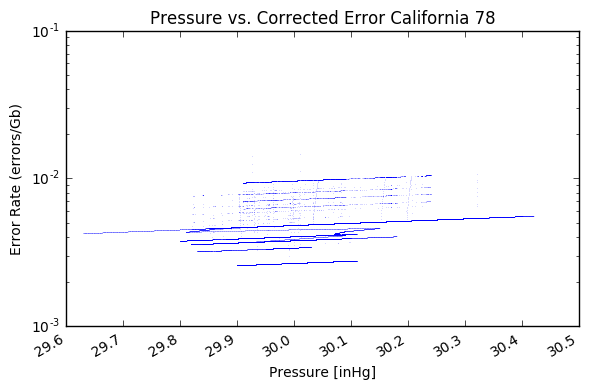

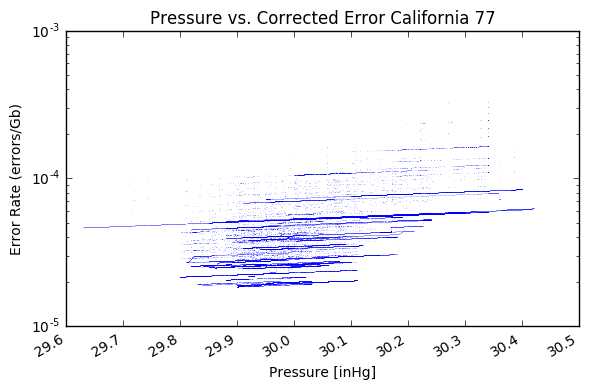

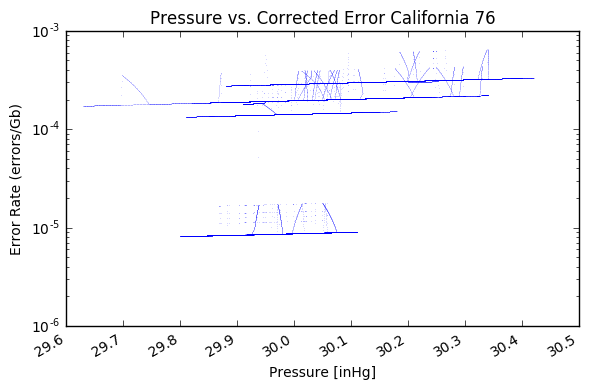

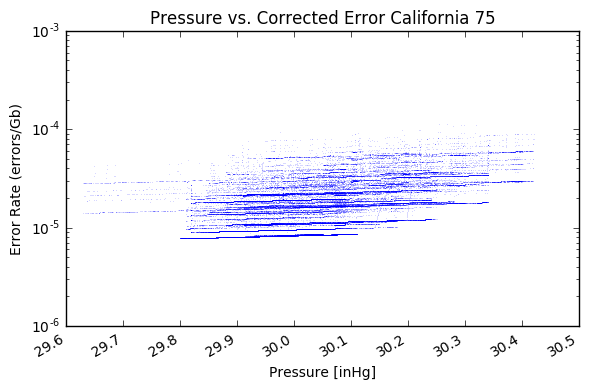

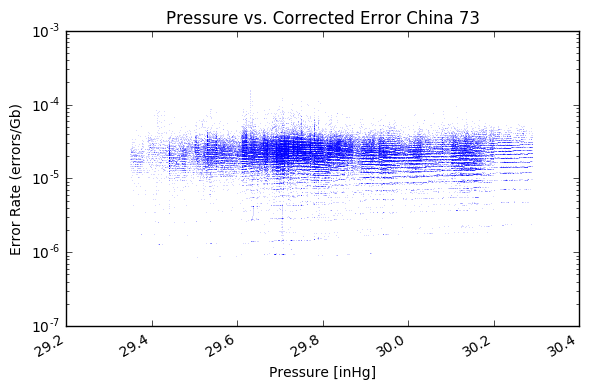

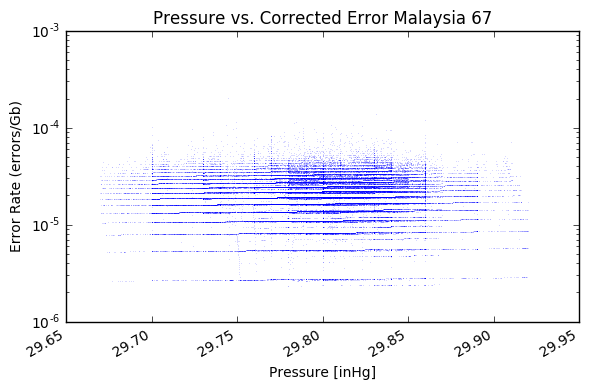

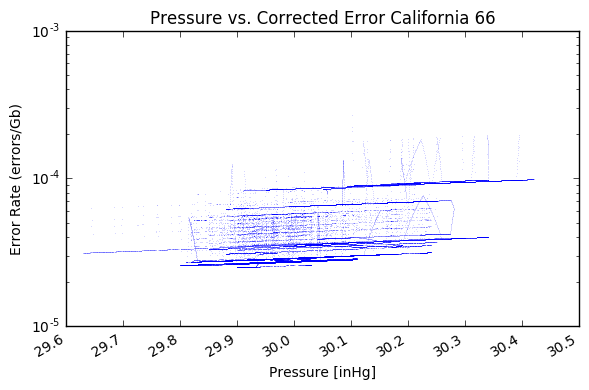

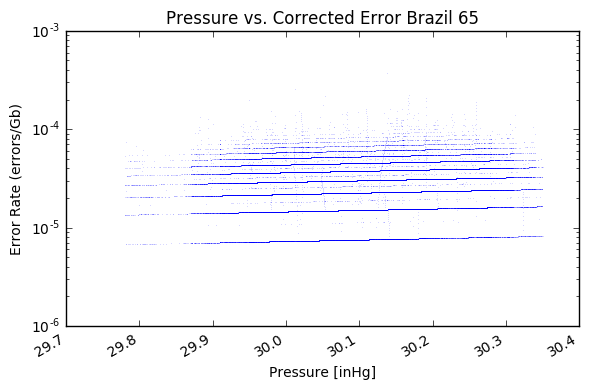

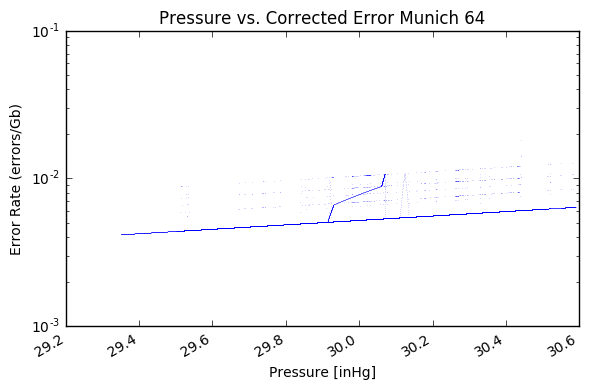

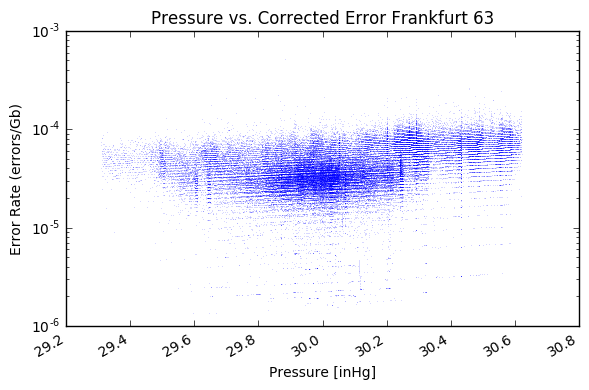

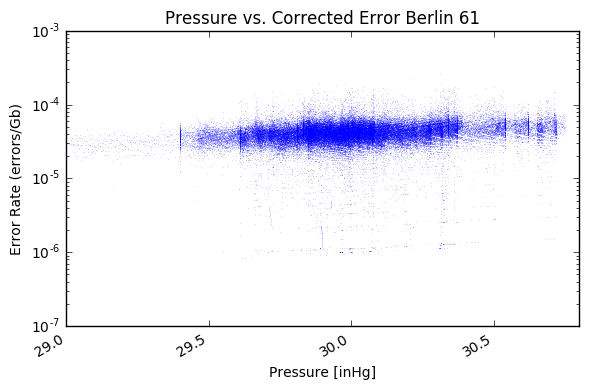

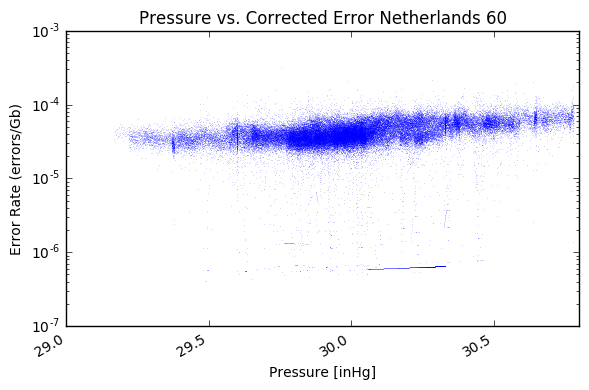

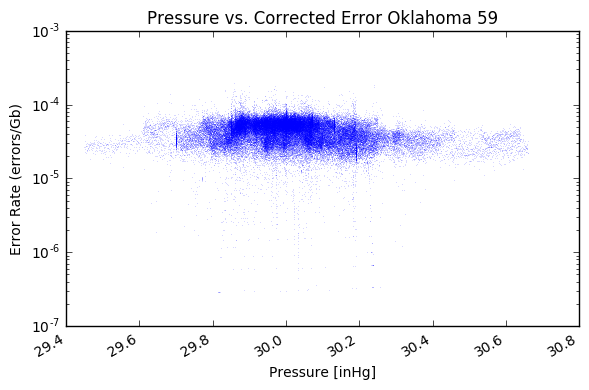

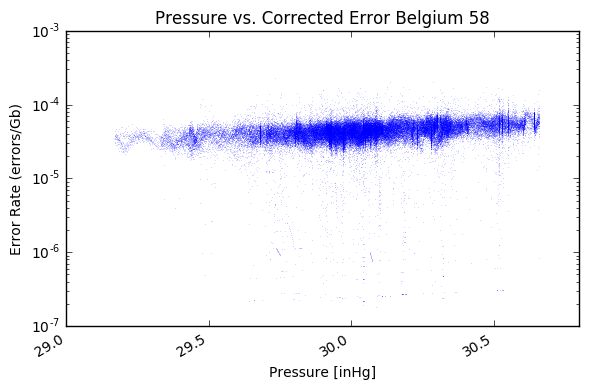

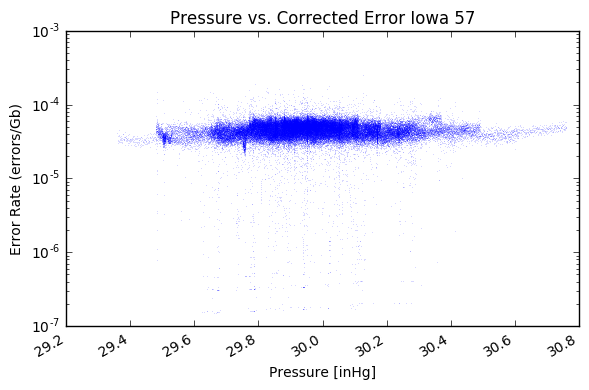

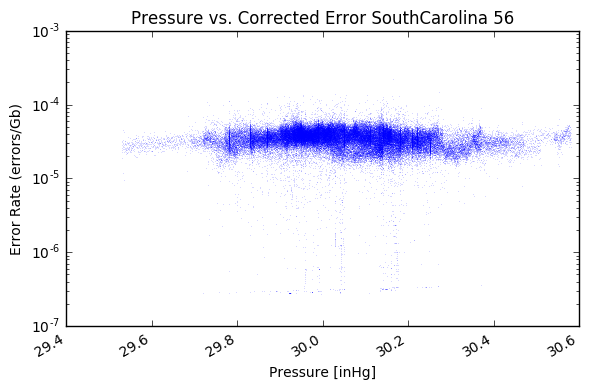

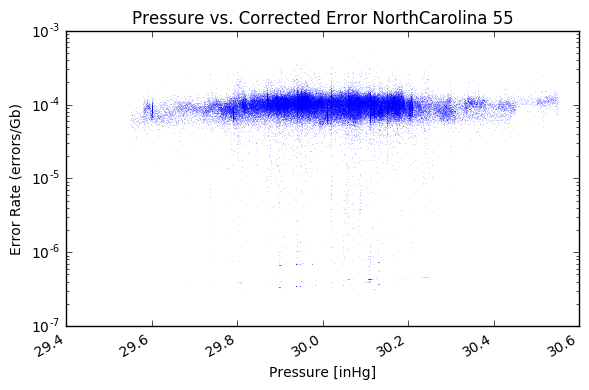

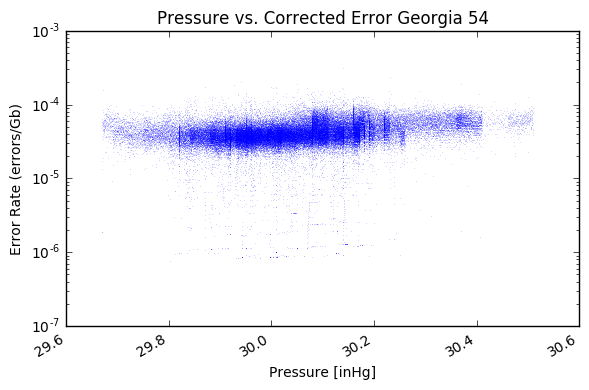

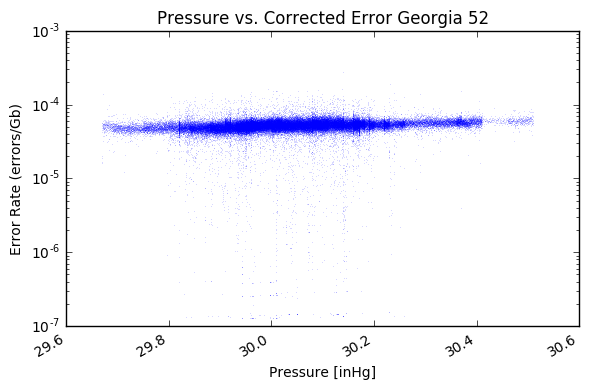

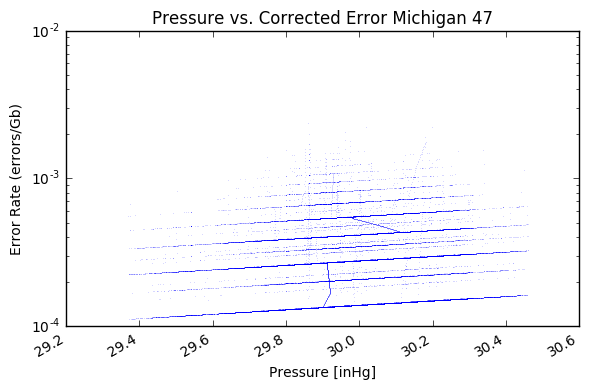

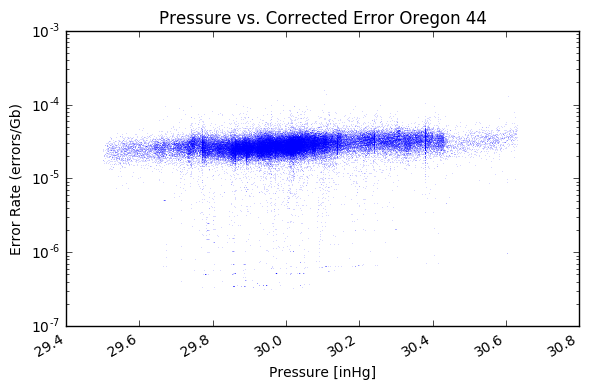

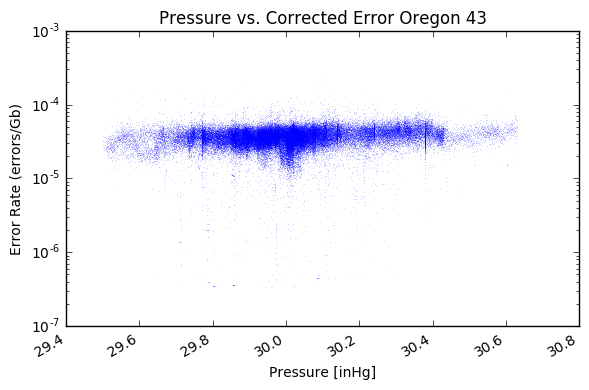

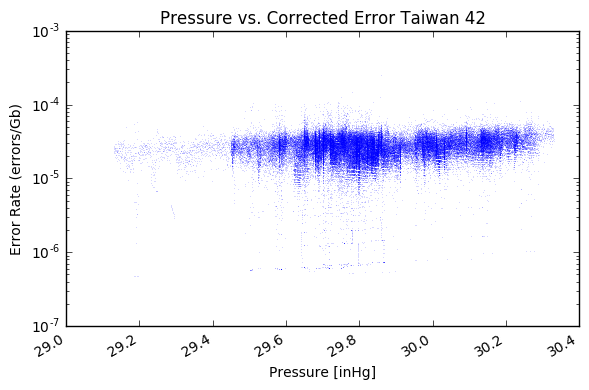

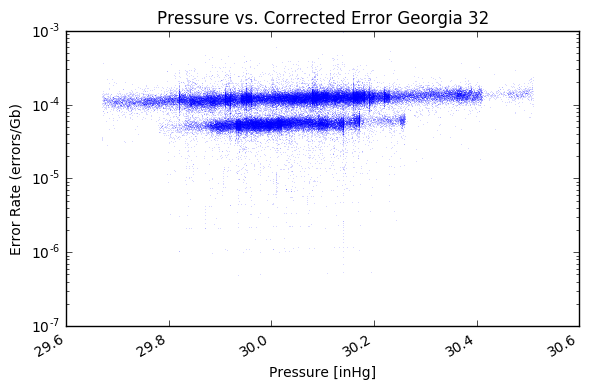

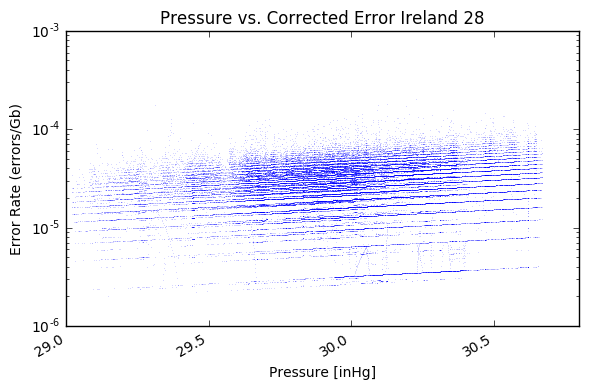

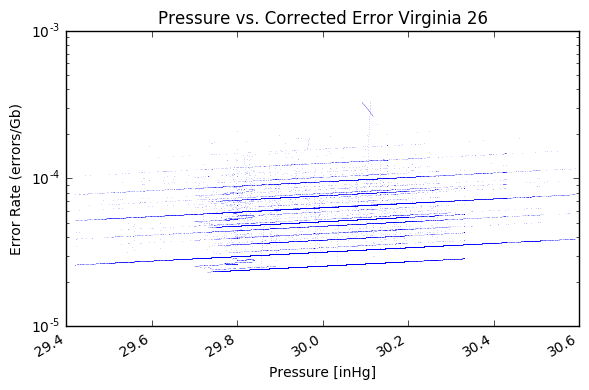

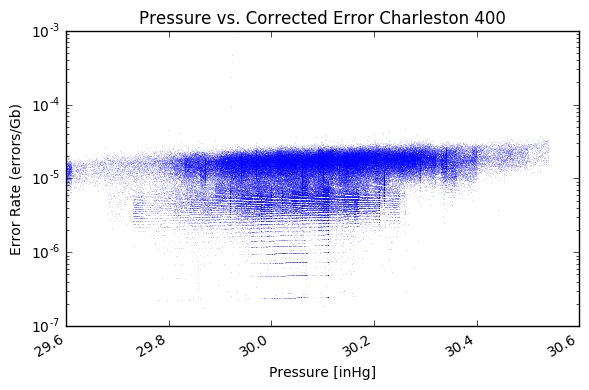

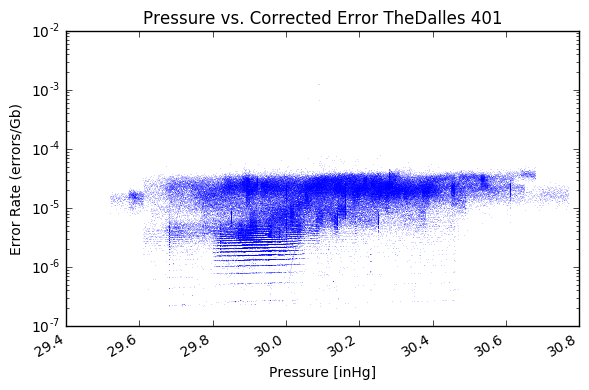

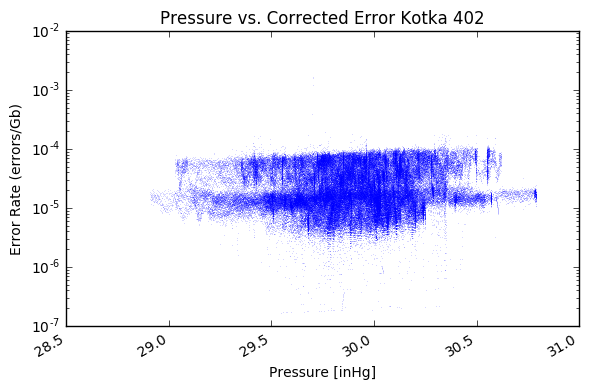

In [76]:
for id_index in range(33):
    errors=dat.error_set.where(dat.error_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample(
        '5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]

    wx=dat.wx_set.where(dat.wx_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample('5T').interpolate(
        method='linear')[tbegin[id_index]:tend[id_index]]

    goes=dat.goes_set.resample('5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]

    nmdb=dat.nmdb_set.resample('5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]
    
    atm_corr=(np.exp(((wx[['MaxSeaLevelPressureIn','MeanSeaLevelPressureIn','MinSeaLevelPressureIn']]*InHg)-sealev)/lambda0)).rename(index=str, columns={'MaxSeaLevelPressureIn':'MaxCorrection', 'MeanSeaLevelPressureIn':'MeanCorrection','MinSeaLevelPressureIn':'MinCorrection'})
    atm_corr.index=pd.to_datetime(atm_corr.index,utc=True)
    
    error_corr=atm_corr['MeanCorrection']*errors['rate']
    error_mx=atm_corr['MaxCorrection']*errors['rate']
    error_mn=atm_corr['MinCorrection']*errors['rate']

    corrected_errors=(pd.concat([error_mx,error_corr,error_mn], axis=1, keys=['MaxRate','MeanRate','MinRate'])).dropna()
    
    fig, ax = plt.subplots()
    ax.set_yscale("log", nonposy='clip')
    #plt.errorbar(wx['MeanSeaLevelPressureIn'], errors['rate'],fmt='.')
    plt.errorbar(wx['MeanSeaLevelPressureIn'], corrected_errors['MeanRate'],fmt='.', markersize=0.1)
    ax.set_ylabel('Error Rate (errors/Gb)')
    ax.set_xlabel('Pressure [inHg]')
    ax.set_title('{0} {1} {2}'.format('Pressure vs. Corrected Error',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index]))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig('{0}{1}{2}{3}'.format('/Users/mskirk/Desktop/GooglePlots/ErrorPressure',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index],'.png'), dpi=200)


Pressure vs. Error rate Merged Plot:

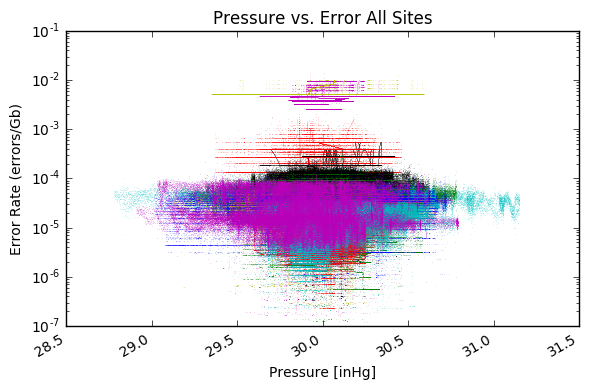

In [85]:
fig, ax = plt.subplots()
ax.set_yscale("log", nonposy='clip')

for id_index in range(33):
    errors=dat.error_set.where(dat.error_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample(
        '5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]

    wx=dat.wx_set.where(dat.wx_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample('5T').interpolate(
        method='linear')[tbegin[id_index]:tend[id_index]]

    goes=dat.goes_set.resample('5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]

    nmdb=dat.nmdb_set.resample('5T').interpolate(method='linear')[tbegin[id_index]:tend[id_index]]
    
    atm_corr=(np.exp(((wx[['MaxSeaLevelPressureIn','MeanSeaLevelPressureIn','MinSeaLevelPressureIn']]*InHg)-sealev)/lambda0)).rename(index=str, columns={'MaxSeaLevelPressureIn':'MaxCorrection', 'MeanSeaLevelPressureIn':'MeanCorrection','MinSeaLevelPressureIn':'MinCorrection'})
    atm_corr.index=pd.to_datetime(atm_corr.index,utc=True)
    
    error_corr=atm_corr['MeanCorrection']*errors['rate']
    error_mx=atm_corr['MaxCorrection']*errors['rate']
    error_mn=atm_corr['MinCorrection']*errors['rate']

    corrected_errors=(pd.concat([error_mx,error_corr,error_mn], axis=1, keys=['MaxRate','MeanRate','MinRate'])).dropna()
    
    plt.errorbar(wx['MeanSeaLevelPressureIn'], errors['rate'],fmt='.', markersize=0.1)
    #plt.errorbar(wx['MeanSeaLevelPressureIn'], corrected_errors['MeanRate'],fmt='.', markersize=0.1)

ax.set_ylabel('Error Rate (errors/Gb)')
ax.set_xlabel('Pressure [inHg]')
ax.set_title('{0} {1}'.format('Pressure vs. Error','All Sites'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('{0}{1}'.format('/Users/mskirk/Desktop/GooglePlots/MergedErrorPressureUncorrected','.png'), dpi=200)


Let's rebin to a 1-day frequency to match the atmospheric pressure data. 

/Users/mskirk/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


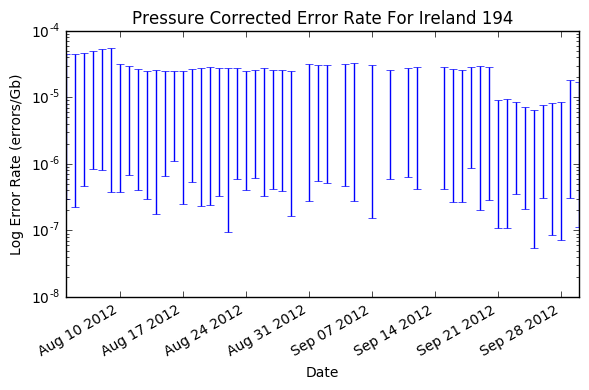

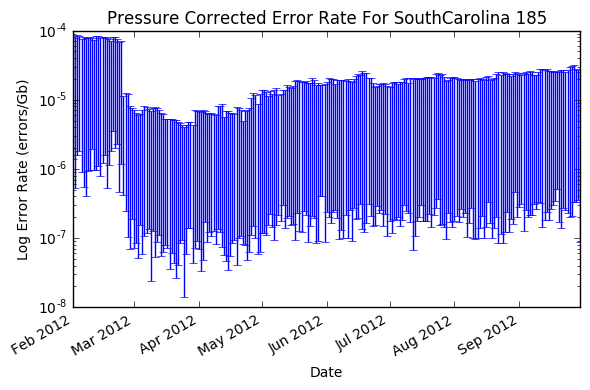

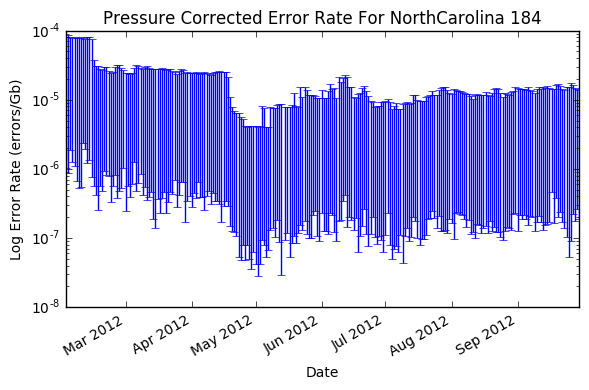

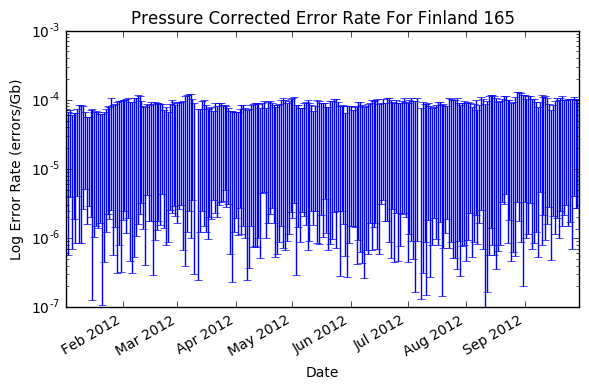

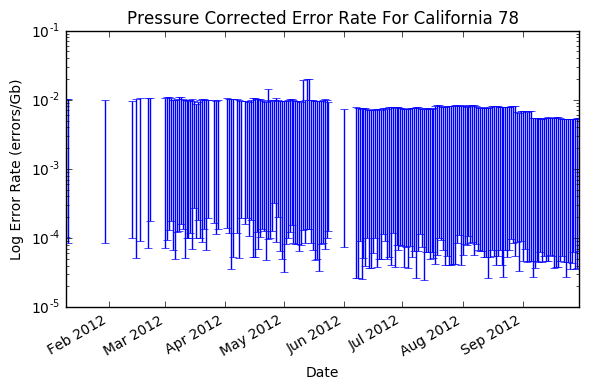

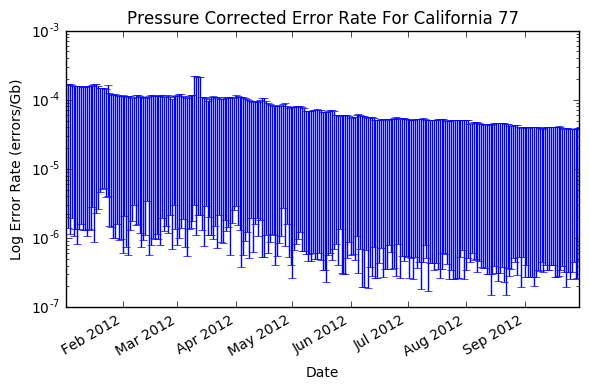

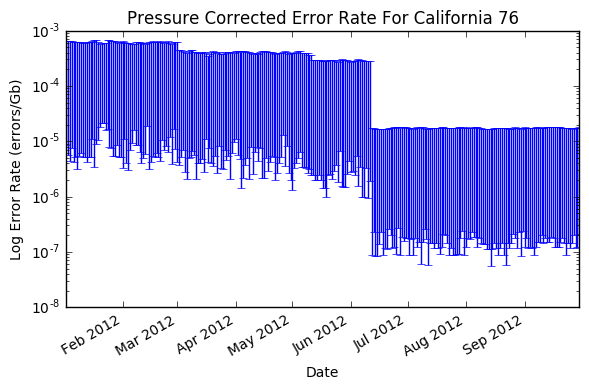

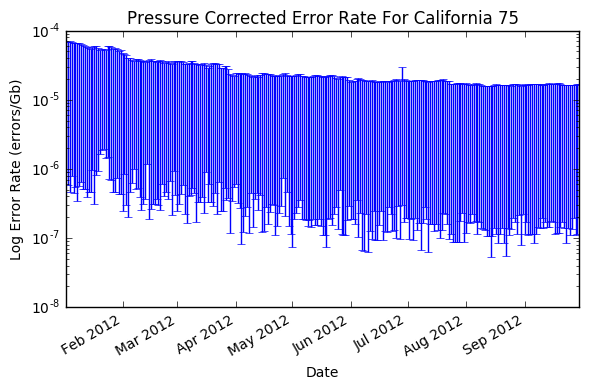

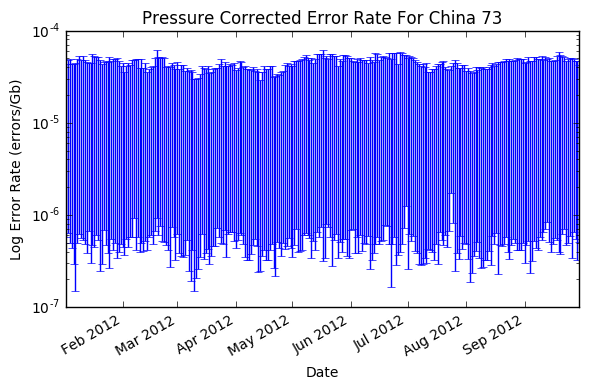

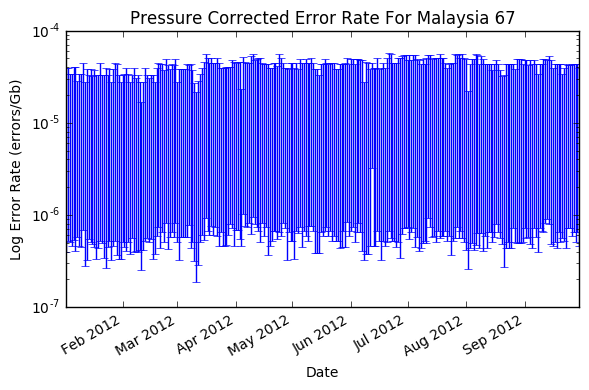

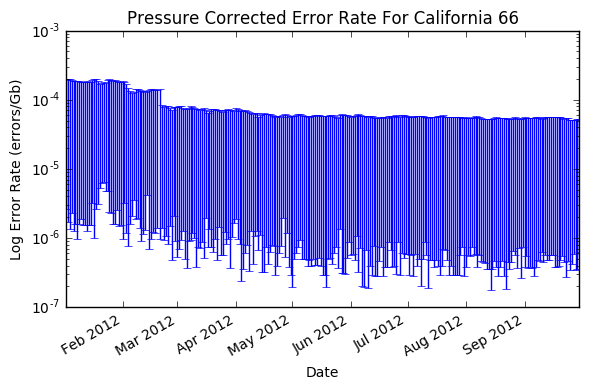

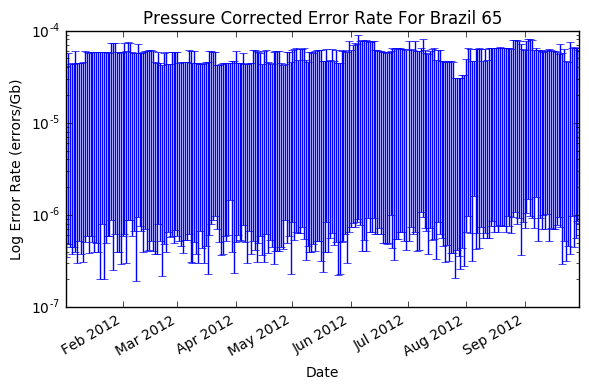

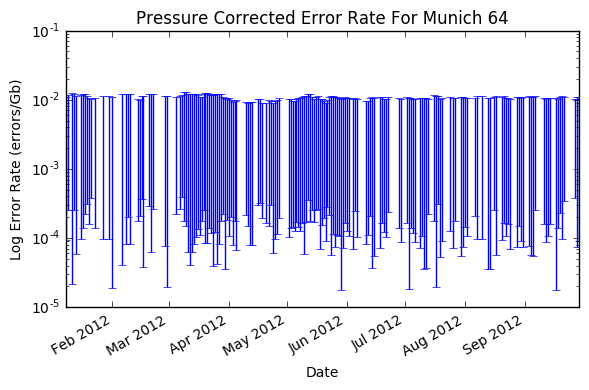

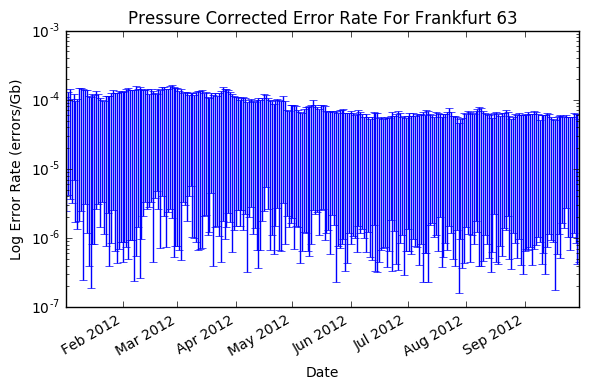

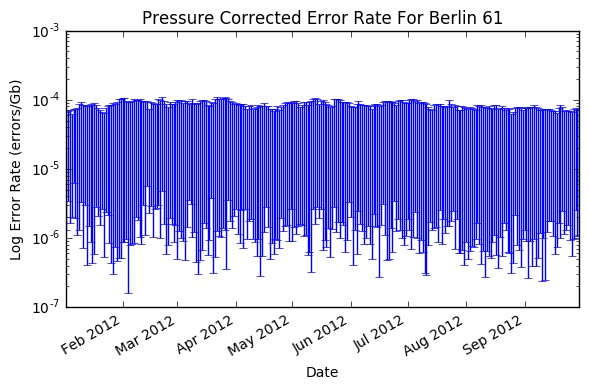

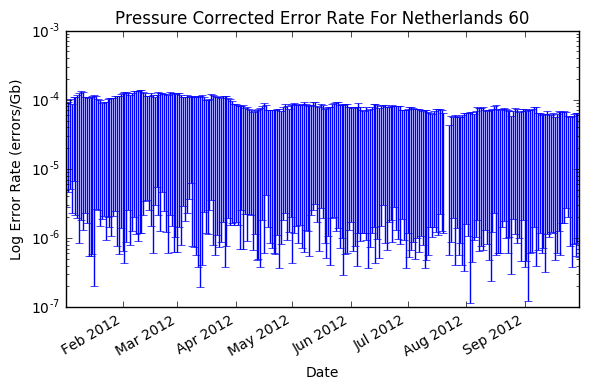

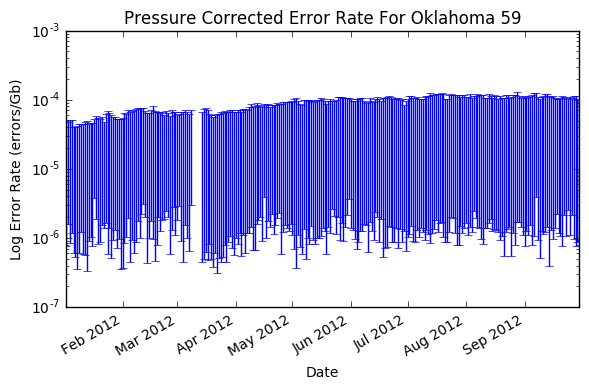

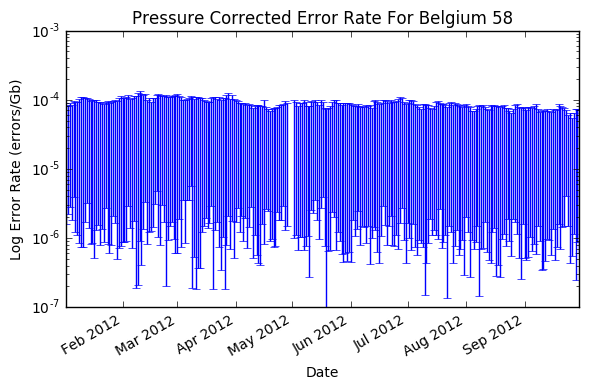

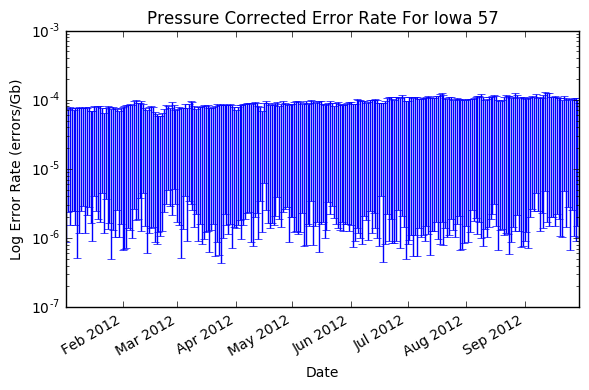

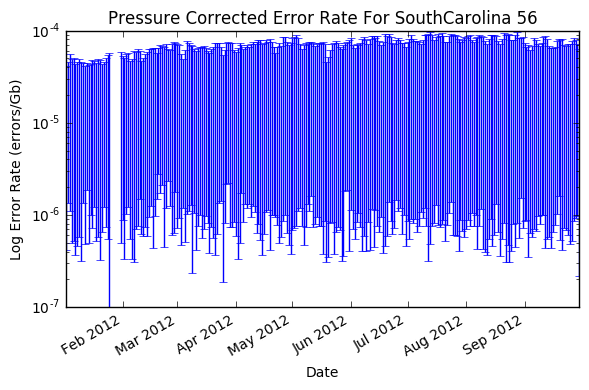

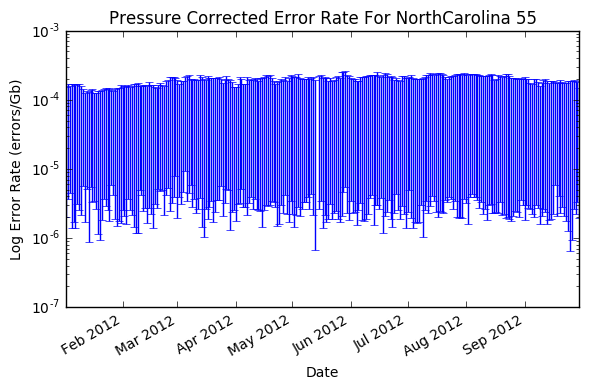

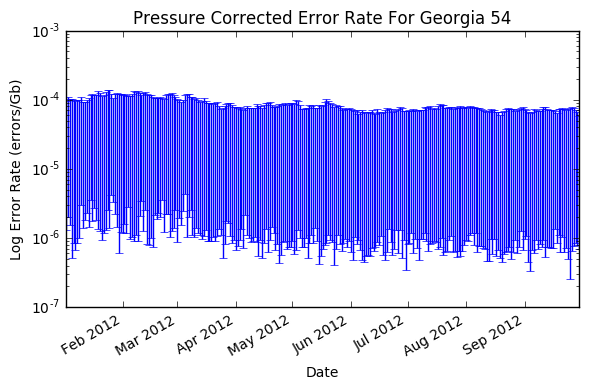

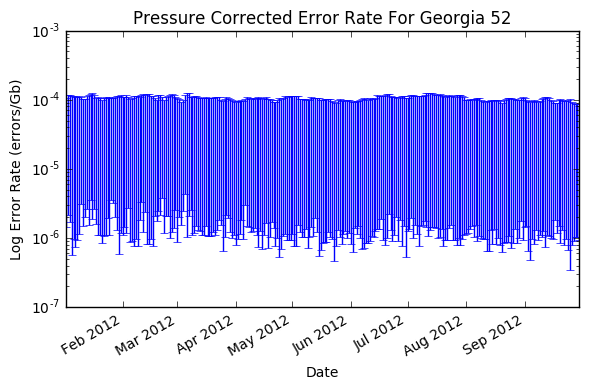

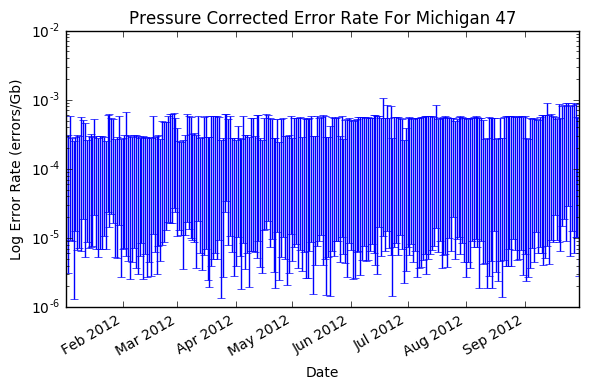

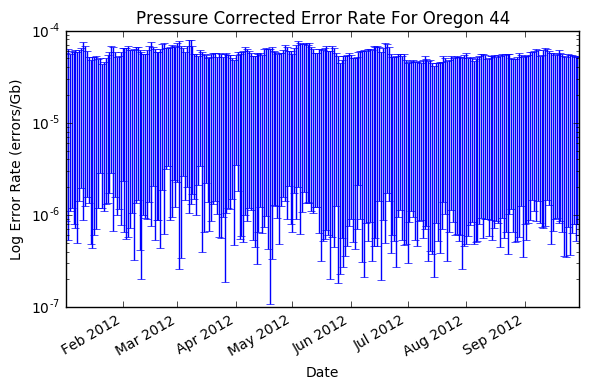

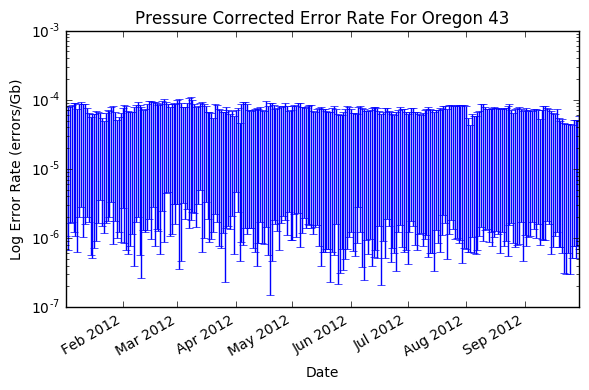

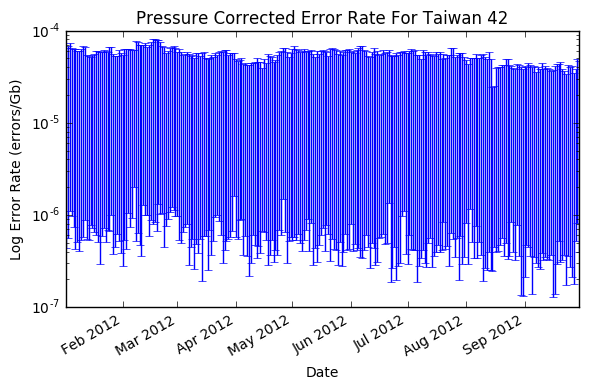

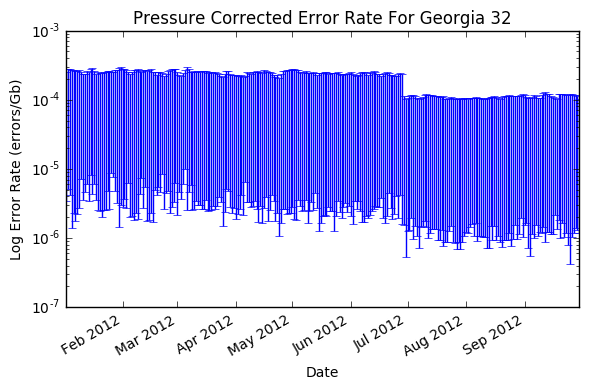

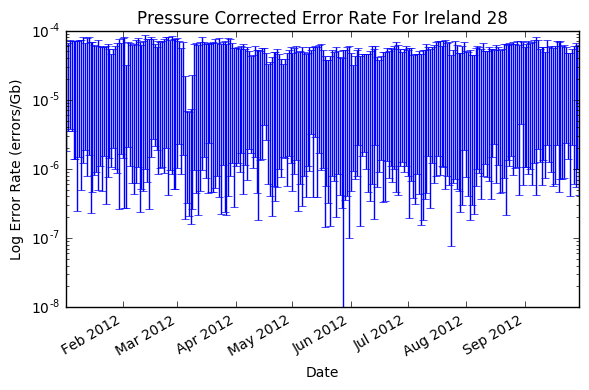

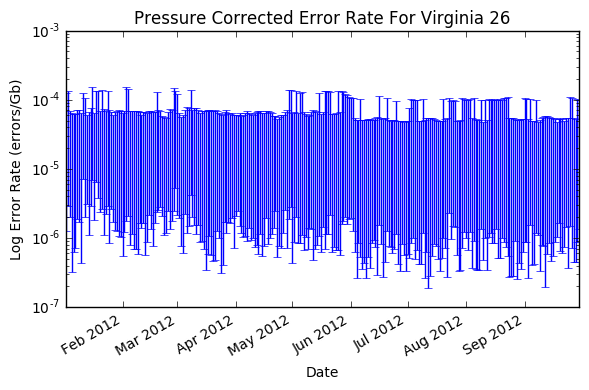

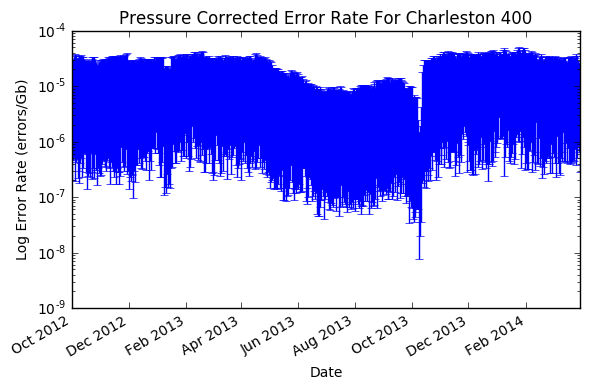

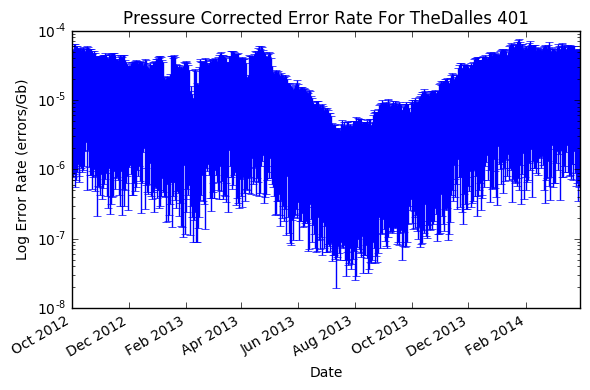

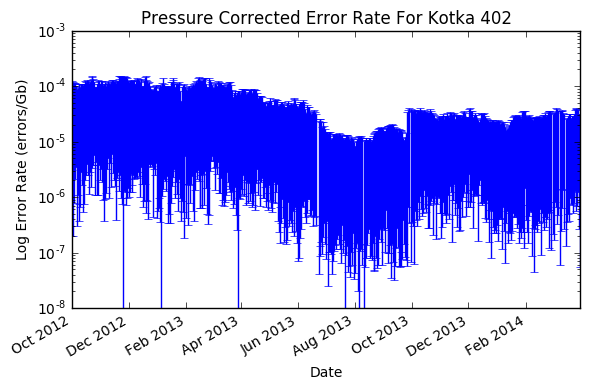

In [31]:
PCor_error_ave = np.zeros_like(error_ave)
PCor_error_std = np.zeros_like(error_ave)

for id_index in range(33):
    errors=dat.error_set.where(dat.error_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample(
        '1D').median()[tbegin[id_index]:tend[id_index]]

    wx=(dat.wx_set.where(dat.wx_set['loc_id'] == dat.site_info['ID'][id_index]).resample('1D').median()[tbegin[id_index]:tend[id_index]]).dropna()

    goes=dat.goes_set.resample('1D').median()[tbegin[id_index]:tend[id_index]]

    nmdb=dat.nmdb_set.resample('1D').median()[tbegin[id_index]:tend[id_index]]
    
    atm_corr=(np.exp(((wx[['MaxSeaLevelPressureIn','MeanSeaLevelPressureIn','MinSeaLevelPressureIn']]*InHg)-sealev)/lambda0)).rename(index=str, columns={'MaxSeaLevelPressureIn':'MaxCorrection', 'MeanSeaLevelPressureIn':'MeanCorrection','MinSeaLevelPressureIn':'MinCorrection'})
    atm_corr.index=pd.to_datetime(atm_corr.index,utc=True)
    
    error_corr=atm_corr['MeanCorrection']*errors['rate']
    error_mx=atm_corr['MaxCorrection']*errors['rate']
    error_mn=atm_corr['MinCorrection']*errors['rate']

    PCor_error_ave[id_index]=np.mean(error_corr)
    PCor_error_std[id_index]=np.std(error_corr)
    
    corrected_errors=(pd.concat([error_mx,error_corr,error_mn], axis=1, keys=['MaxRate','MeanRate','MinRate'])).dropna()
    
    fig, ax = plt.subplots()
    ax.set_yscale("log", nonposy='clip')
    #plt.errorbar(corrected_errors.index, corrected_errors['MeanRate'],fmt='.', markersize=0.5)
    plt.errorbar(corrected_errors.index, corrected_errors['MeanRate'], yerr=[corrected_errors['MinRate'],corrected_errors['MaxRate']],fmt='.', markersize=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Error Rate (errors/Gb)')
    ax.set_title('{0} {1} {2}'.format('Pressure Corrected Error Rate For',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index]))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig('{0}{1}{2}{3}'.format('/Users/mskirk/Desktop/GooglePlots/Day',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index],'.png'), dpi=200)


More day Binning:

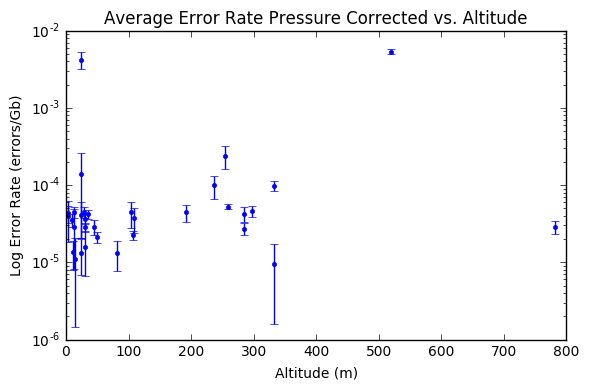

In [26]:
ax = plt.subplot(111)
ax.set_yscale("log", nonposy='clip')

plt.errorbar(dat.site_info['Altitude'], PCor_error_ave, yerr=PCor_error_std,fmt='.')
ax.set_xlabel('Altitude (m)')
ax.set_ylabel('Log Error Rate (errors/Gb)')
ax.set_title('Average Error Rate Pressure Corrected vs. Altitude')
plt.tight_layout()
plt.savefig('{0}{1}{2}'.format('/Users/mskirk/Desktop/GooglePlots/DayBin/','PCorrErrorAltitude','.png'), dpi=200)

In [16]:
GLE1=pd.to_datetime(['2012-05-17 01:55','2012-05-17 08:00'] , utc=True)
GLE1_begin=pd.to_datetime('2012-05-16 00:00', utc=True)
GLE1_end=pd.to_datetime('2012-05-19 00:00', utc=True)

GLE2=pd.to_datetime(['2014-01-06 08:15', '2014-01-06 16:15'], utc=True)
GLE2_begin=pd.to_datetime('2014-01-06 00:00', utc=True)
GLE2_end=pd.to_datetime('2014-01-09 00:00', utc=True)

/Users/mskirk/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


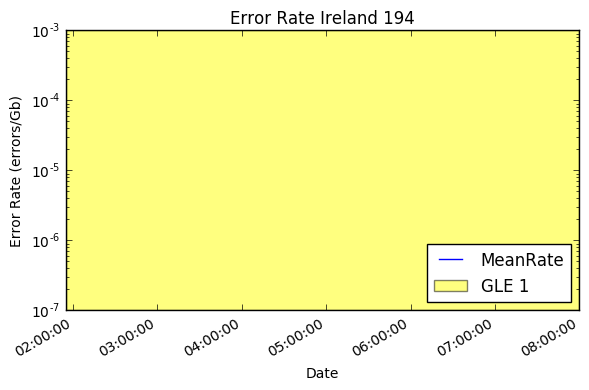

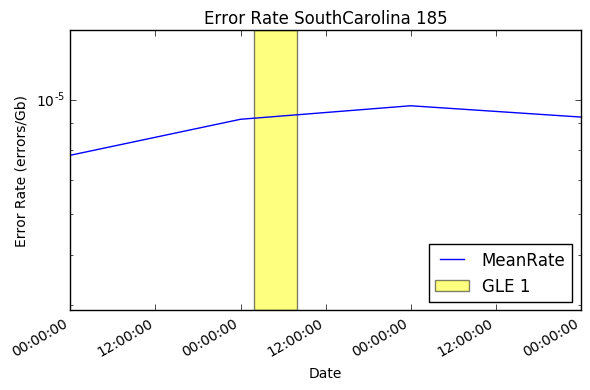

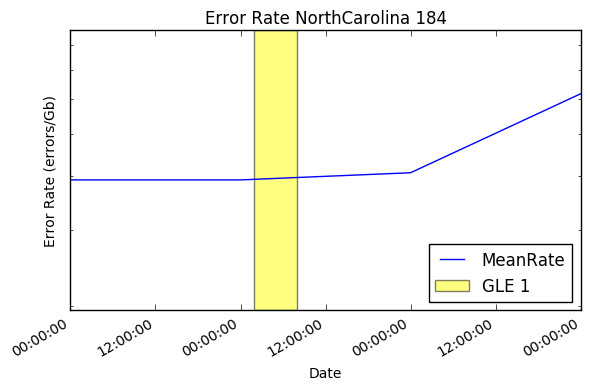

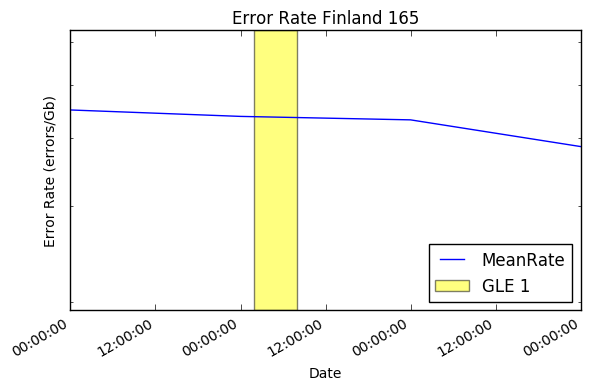

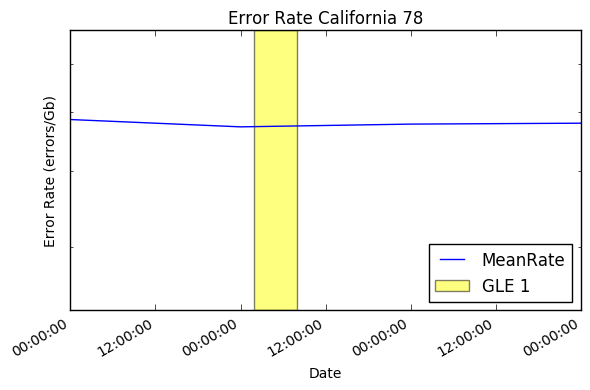

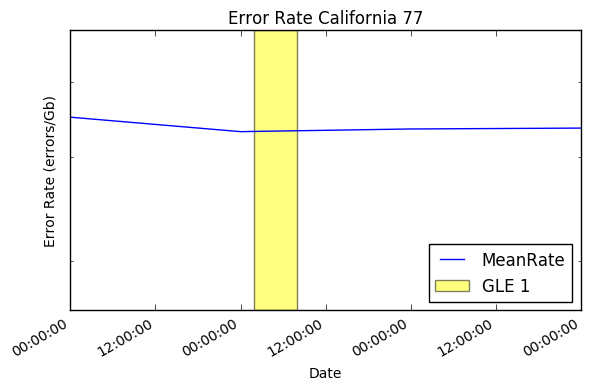

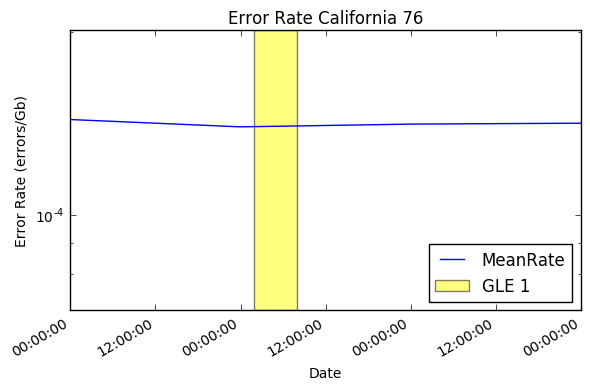

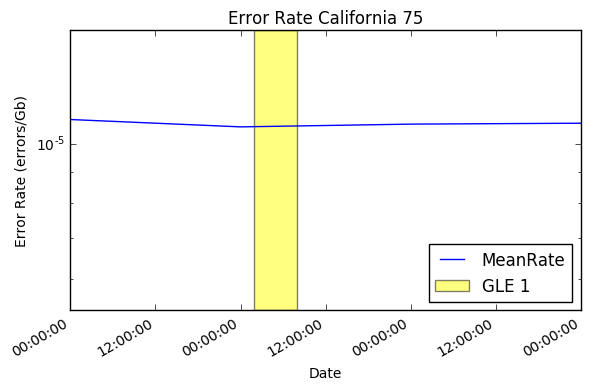

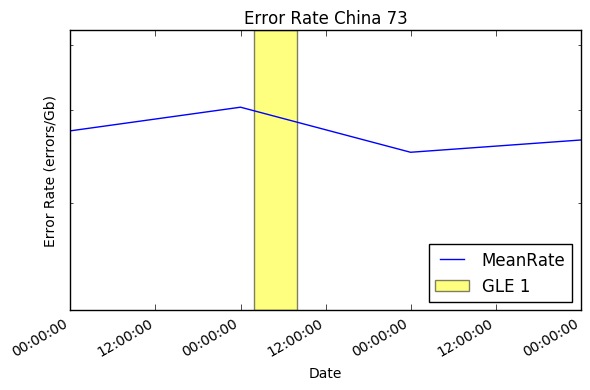

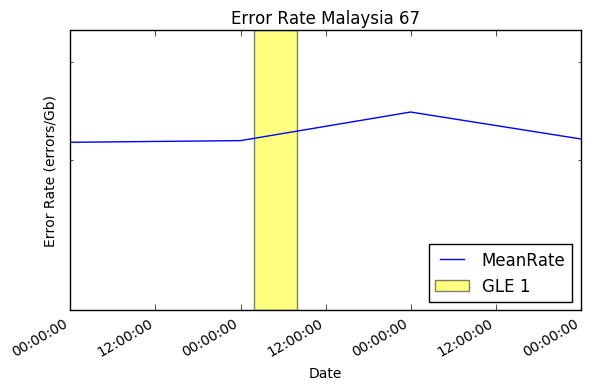

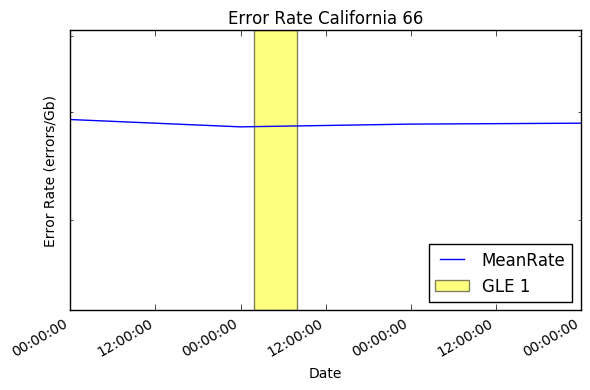

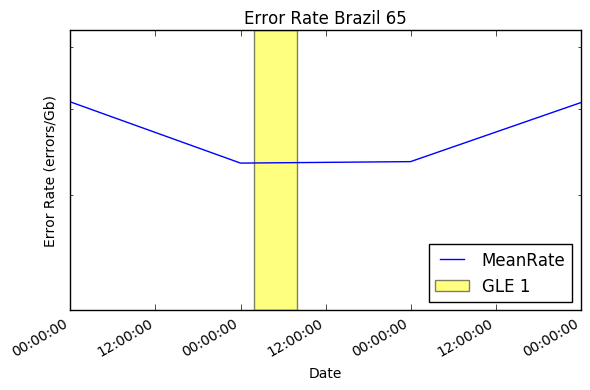

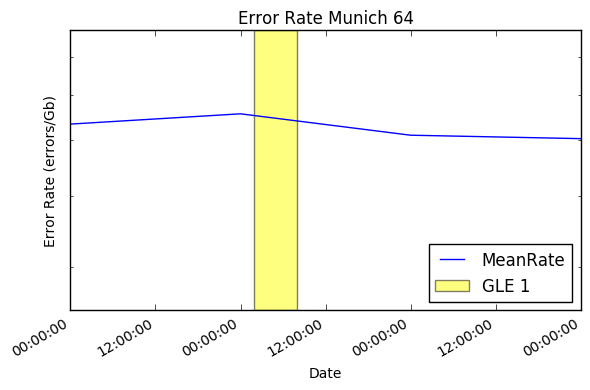

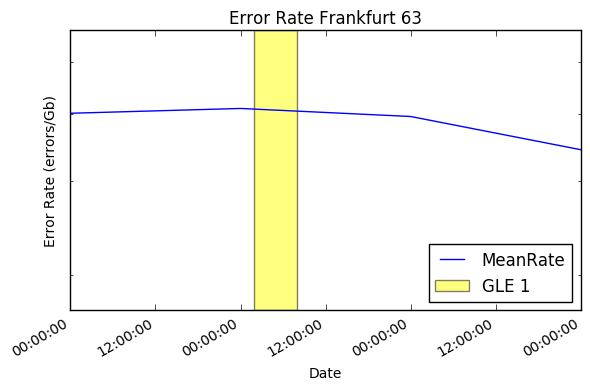

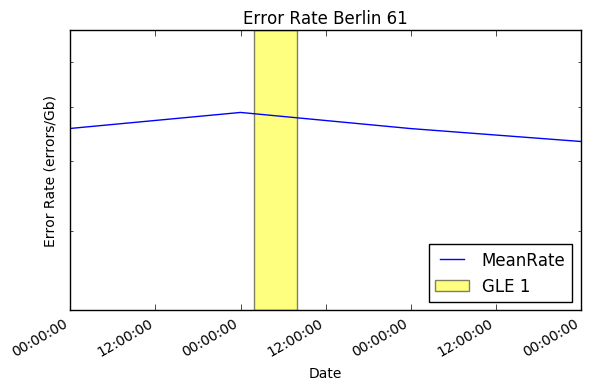

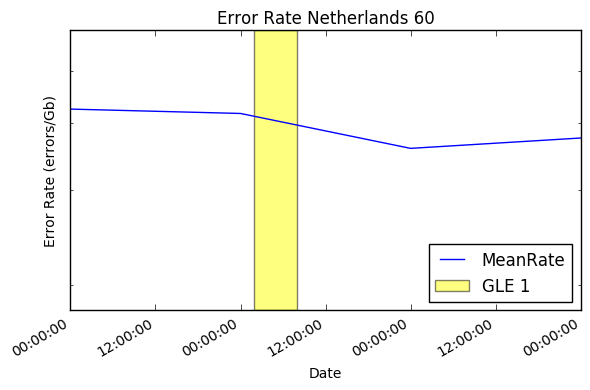

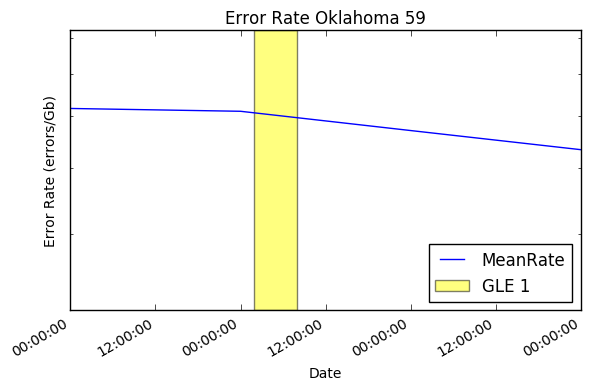

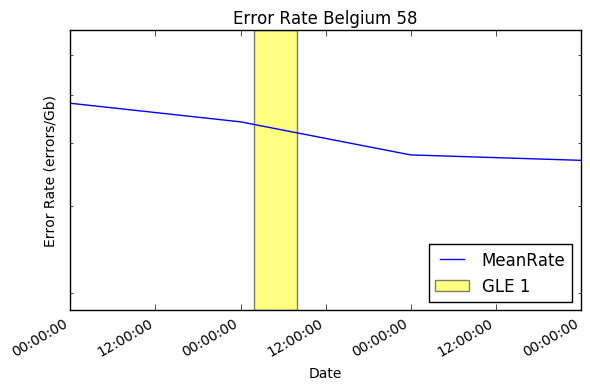

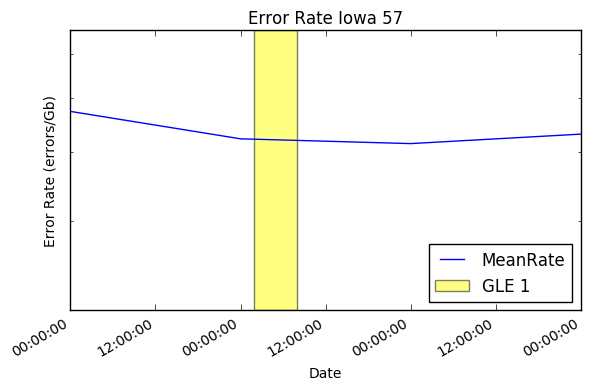

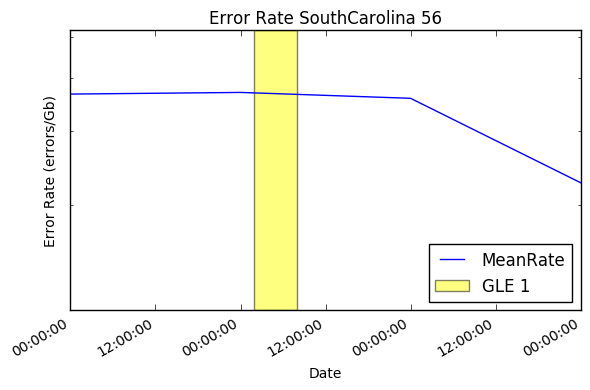

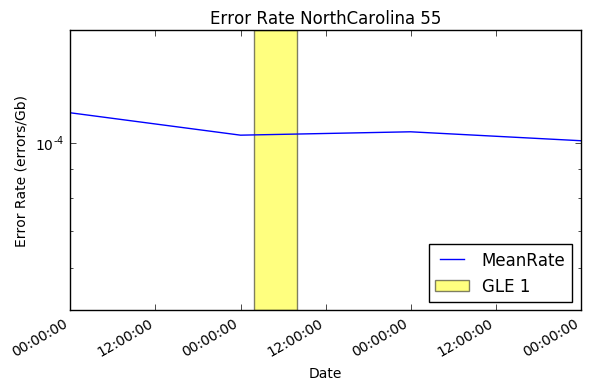

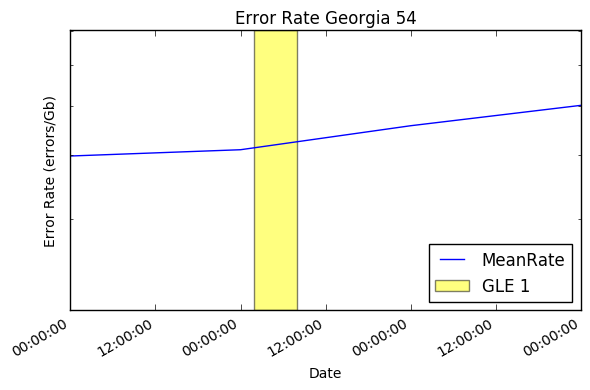

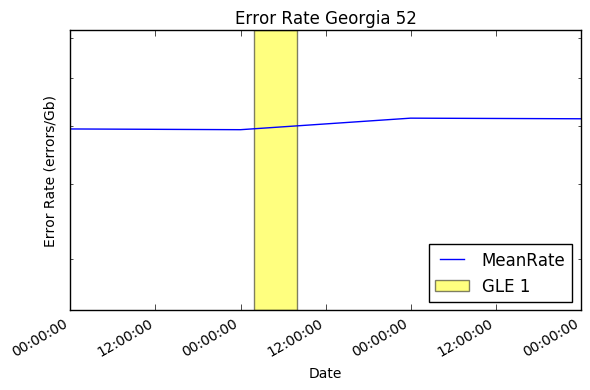

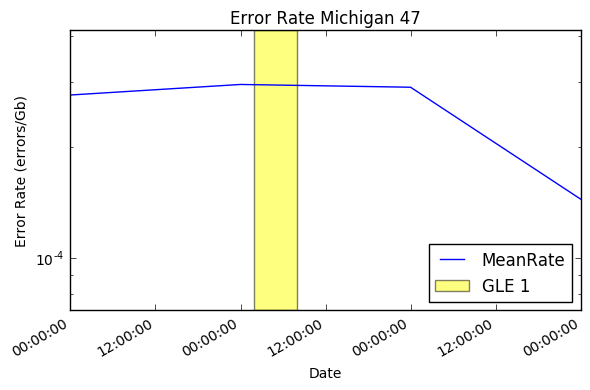

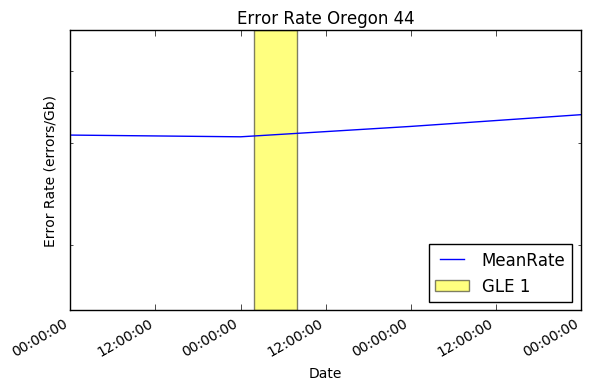

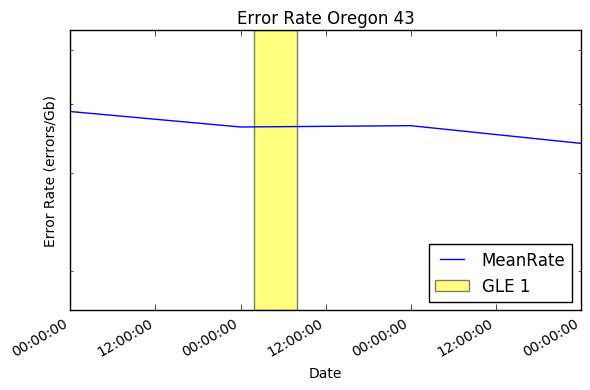

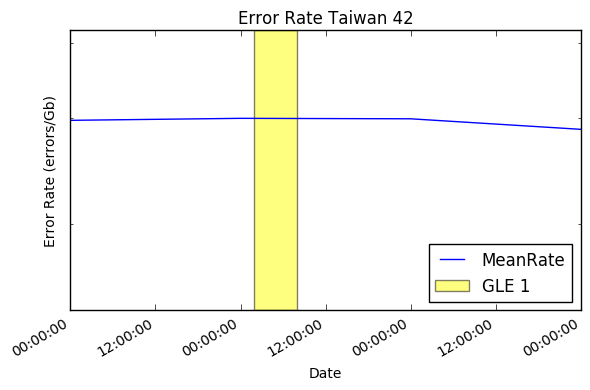

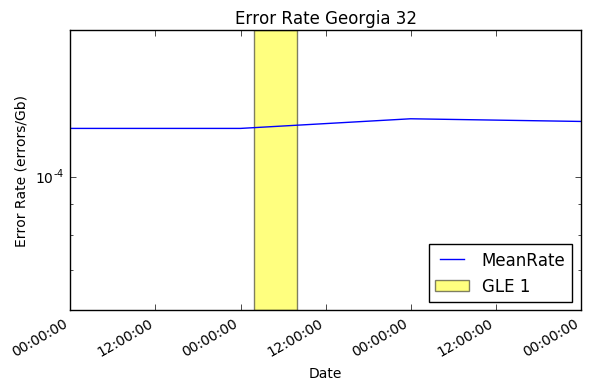

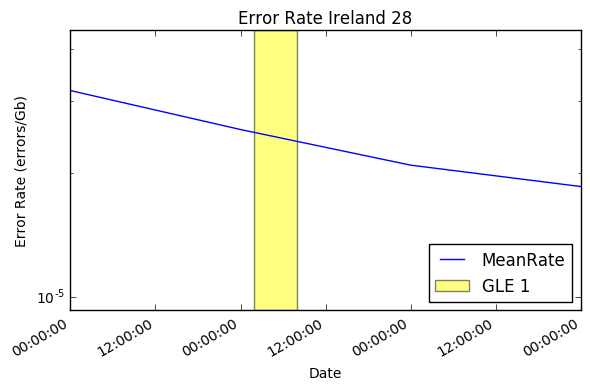

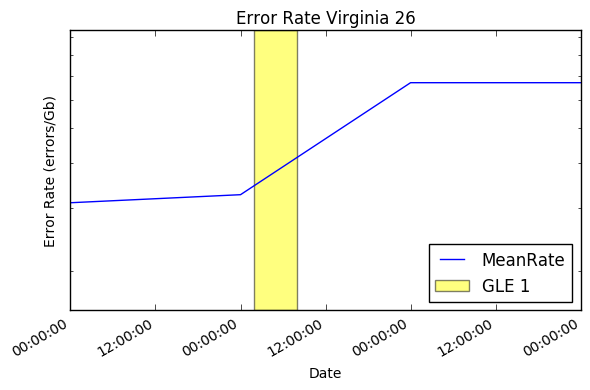

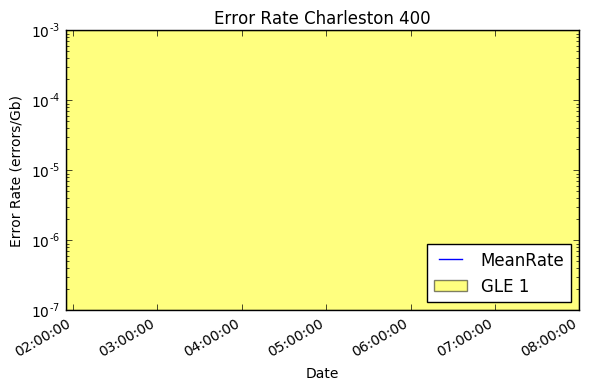

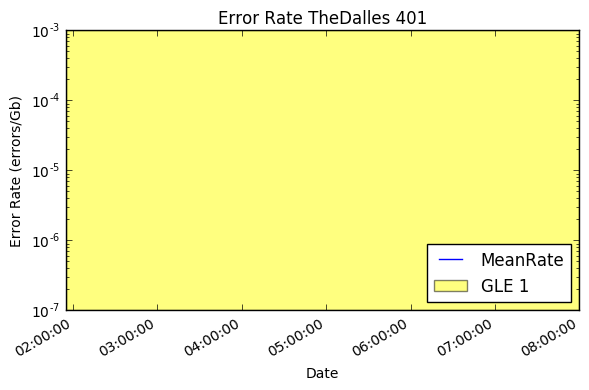

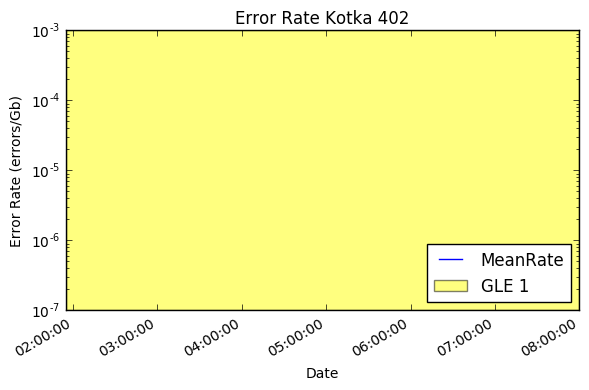

In [30]:
for id_index in range(33):
    errors=dat.error_set.where(dat.error_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample(
        '1D').median()[GLE1_begin:GLE1_end]

    wx=(dat.wx_set.where(dat.wx_set['loc_id'] == dat.site_info['ID'][id_index]).resample('1D').median()[GLE1_begin:GLE1_end]).dropna()

    goes=dat.goes_set.resample('1D').median()[GLE1_begin:GLE1_end]

    nmdb=dat.nmdb_set.resample('1D').median()[GLE1_begin:GLE1_end]
    
    atm_corr=(np.exp(((wx[['MaxSeaLevelPressureIn','MeanSeaLevelPressureIn','MinSeaLevelPressureIn']]*InHg)-sealev)/lambda0)).rename(index=str, columns={'MaxSeaLevelPressureIn':'MaxCorrection', 'MeanSeaLevelPressureIn':'MeanCorrection','MinSeaLevelPressureIn':'MinCorrection'})
    atm_corr.index=pd.to_datetime(atm_corr.index,utc=True)
    
    error_corr=atm_corr['MeanCorrection']*errors['rate']
    error_mx=atm_corr['MaxCorrection']*errors['rate']
    error_mn=atm_corr['MinCorrection']*errors['rate']

    corrected_errors=(pd.concat([error_mx,error_corr,error_mn], axis=1, keys=['MaxRate','MeanRate','MinRate'])).dropna()
    
    fig, ax = plt.subplots(1)
    ax.set_yscale("log", nonposy='clip')
    ylow, yhigh = ax.set_ylim([np.min(corrected_errors['MeanRate'])*0.5,np.max(corrected_errors['MeanRate'])*1.4])
    plt.plot(errors.index, corrected_errors['MeanRate'])
    # Alternative plotting without pressure correction for comparison
    #ylow, yhigh = ax.set_ylim([0,np.max(errors['rate'])]) 
    #plt.plot(errors.index, errors['rate'])
    ax.fill_betweenx([ylow,yhigh], GLE1[0],GLE1[1], facecolor='yellow', alpha=0.5, label='GLE 1')    
    ax.set_xlabel('Date')
    ax.set_ylabel('Error Rate (errors/Gb)')
    ax.set_title('{0} {1} {2}'.format('Error Rate',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index]))
    ax.legend(loc='lower right')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig('{0}{1}{2}{3}'.format('/Users/mskirk/Desktop/GooglePlots/GLE1_',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index],'.png'), dpi=200)


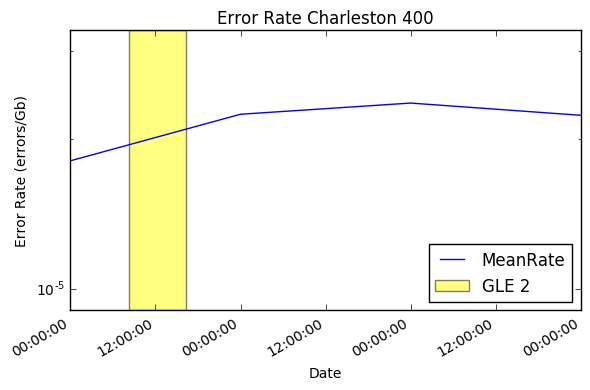

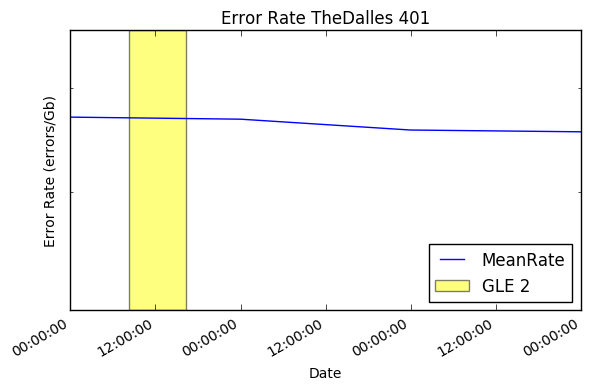

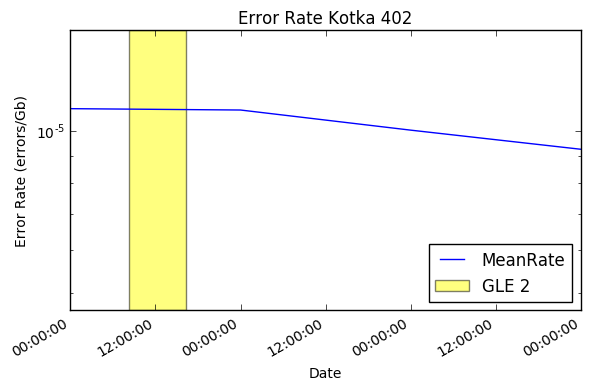

In [17]:
for id_index in [30,31,32]:
    errors=dat.error_set.where(dat.error_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample(
        '1D').median()[GLE2_begin:GLE2_end]

    wx=dat.wx_set.where(dat.wx_set['loc_id'] == dat.site_info['ID'][id_index]).dropna().resample('1D').median()[GLE2_begin:GLE2_end]

    goes=dat.goes_set.resample('1D').median()[GLE2_begin:GLE2_end]

    nmdb=dat.nmdb_set.resample('1D').median()[GLE2_begin:GLE2_end]
    
    atm_corr=(np.exp(((wx[['MaxSeaLevelPressureIn','MeanSeaLevelPressureIn','MinSeaLevelPressureIn']]*InHg)-sealev)/lambda0)).rename(index=str, columns={'MaxSeaLevelPressureIn':'MaxCorrection', 'MeanSeaLevelPressureIn':'MeanCorrection','MinSeaLevelPressureIn':'MinCorrection'})
    atm_corr.index=pd.to_datetime(atm_corr.index,utc=True)
    
    error_corr=atm_corr['MeanCorrection']*errors['rate']
    error_mx=atm_corr['MaxCorrection']*errors['rate']
    error_mn=atm_corr['MinCorrection']*errors['rate']

    corrected_errors=(pd.concat([error_mx,error_corr,error_mn], axis=1, keys=['MaxRate','MeanRate','MinRate'])).dropna()
    
    fig, ax = plt.subplots(1)
    ax.set_yscale("log", nonposy='clip')
    ylow, yhigh = ax.set_ylim([np.min(corrected_errors['MeanRate'])*0.5,np.max(corrected_errors['MeanRate'])*1.4])
    plt.plot(errors.index, corrected_errors['MeanRate'])
    # Alternative plotting without pressure correction for comparison
    #ylow, yhigh = ax.set_ylim([0,np.max(errors['rate'])])
    #plt.plot(errors.index, errors['rate'])
    ax.fill_betweenx([ylow,yhigh], GLE2[0],GLE2[1], facecolor='yellow', alpha=0.5, label='GLE 2')    
    ax.set_xlabel('Date')
    ax.set_ylabel('Error Rate (errors/Gb)')
    ax.set_title('{0} {1} {2}'.format('Error Rate',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index]))
    ax.legend(loc='lower right')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.savefig('{0}{1}{2}{3}'.format('/Users/mskirk/Desktop/GooglePlots/GLE2_',dat.site_info['Site'][id_index],dat.site_info['ID'][id_index],'.png'), dpi=200)
